# All Types of Argo/EM-APEX CTD Graphs (Built-In + My Own Flare)

In [1]:
#All the imports I utalized to allow any code to run across any of my notebooks, mostly for Argo data
import xarray as xr
xr.set_options(display_style="html", display_expand_attrs=False);
from matplotlib import pyplot as plt
plt.style.use('default')
import cartopy
import cartopy.crs as ccrs
import argopy
import numpy as np
import os, shutil
import pandas as pd
from pathlib import Path
import seawater as sw

from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher(src='erddap', parallel=True)

from argopy import IndexFetcher as ArgoIndexFetcher

from argopy.plot import scatter_map
from argopy import IndexFetcher as ArgoIndexFetcher
from argopy import OceanOPSDeployments
from argopy import TopoFetcher

## Different Capabilities of CTD Graphs: Argo

The first step I took was to figure out how to access CTD data from Argo floats! There is a built in function that I only slightly altered depending on the goal!

### How to include multiple floats and their first ascending (red) and descending (blue) profile on one graph, although please check that your chosen floats actually have descending profiles, as not all do. Otherwise, the blue and red just represent the first and second profiles taken.

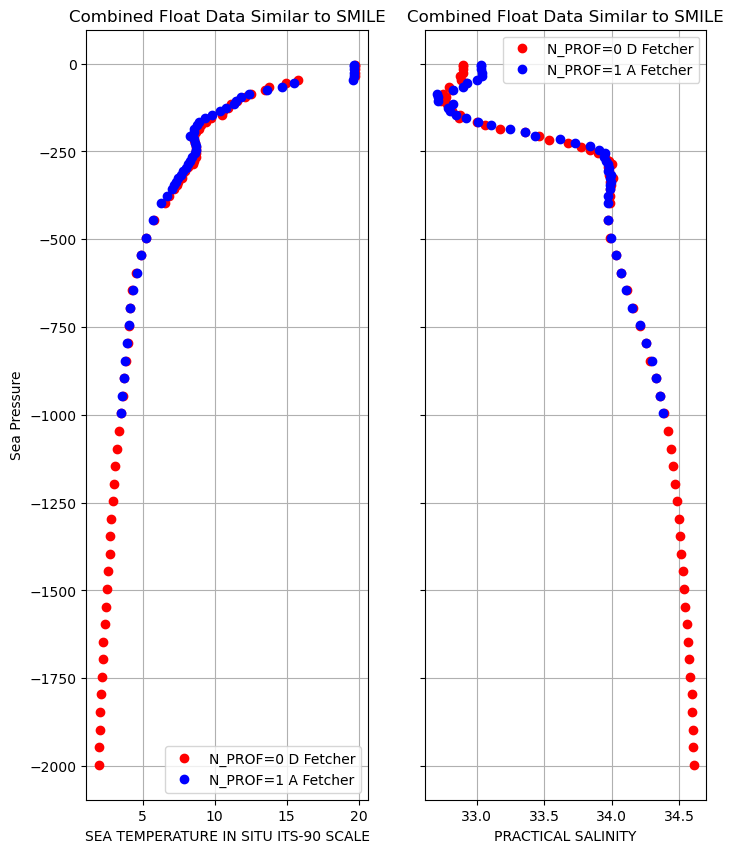

In [2]:
apDS = argo_loader.float([5906520,4900276,5903741,5900639,4900816,5901468]).load().data #This is where you list the floats you want using WMO number
data = apDS.argo.point2profile() #What does the point2profile mean? Lat, Lon, and time are arranged by number of points, run the notebook and compare data structure, for the first one you have one point at each place and time that has its own variable 

fig, ax = plt.subplots(1, 2, figsize=(8,10), sharey=True) #The 1,2 refers to columns and rows of where the subplots are, and sharey means they share a y-axis

#Temperature
ax[0].plot(data.TEMP[0],-data.PRES[0],'ro',label='N_PROF=0 D Fetcher') #The label provided in a legend
ax[0].plot(data.TEMP[1],-data.PRES[1],'bo',label='N_PROF=1 A Fetcher')
ax[0].set_xlabel(data['TEMP'].attrs['long_name']) #It is looking at the attribute names and pulling it in as the title
ax[0].set_ylabel(data['PRES'].attrs['long_name'])
ax[0].set_title('Combined Float Data Similar to SMILE')
ax[0].grid() 
ax[0].legend();

#Salinity
ax[1].plot(data.PSAL[0],-data.PRES[0],'ro',label='N_PROF=0 D Fetcher')
ax[1].plot(data.PSAL[1],-data.PRES[1],'bo',label='N_PROF=1 A Fetcher')
ax[1].set_xlabel(data['PSAL'].attrs['long_name'])
ax[1].set_title('Combined Float Data Similar to SMILE')
ax[1].grid()
ax[1].legend();

### How to include multiple floats and their first ascending (red) and descending (blue) profile on individual graphs based on WMO float ID.

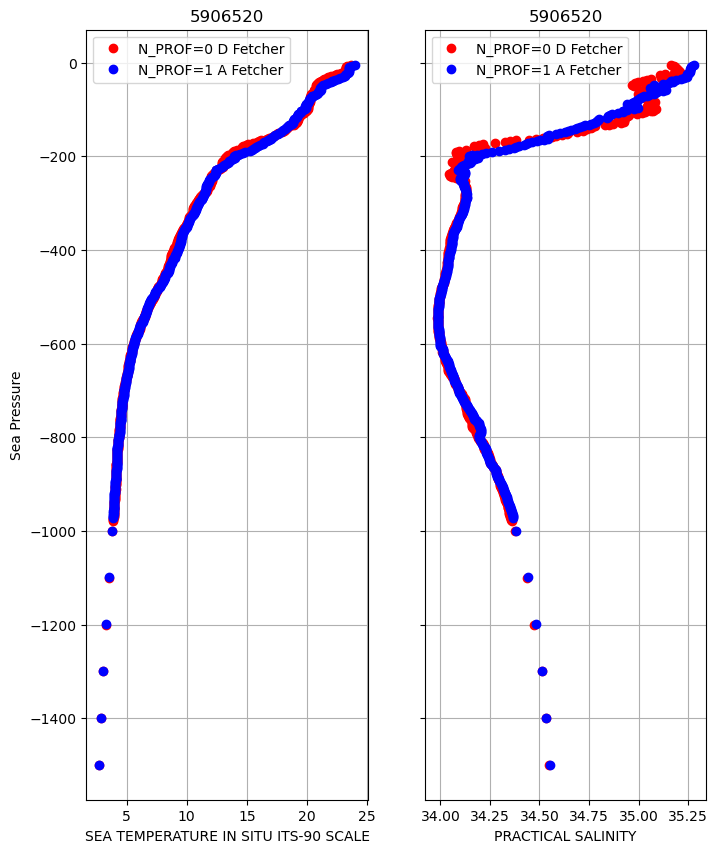

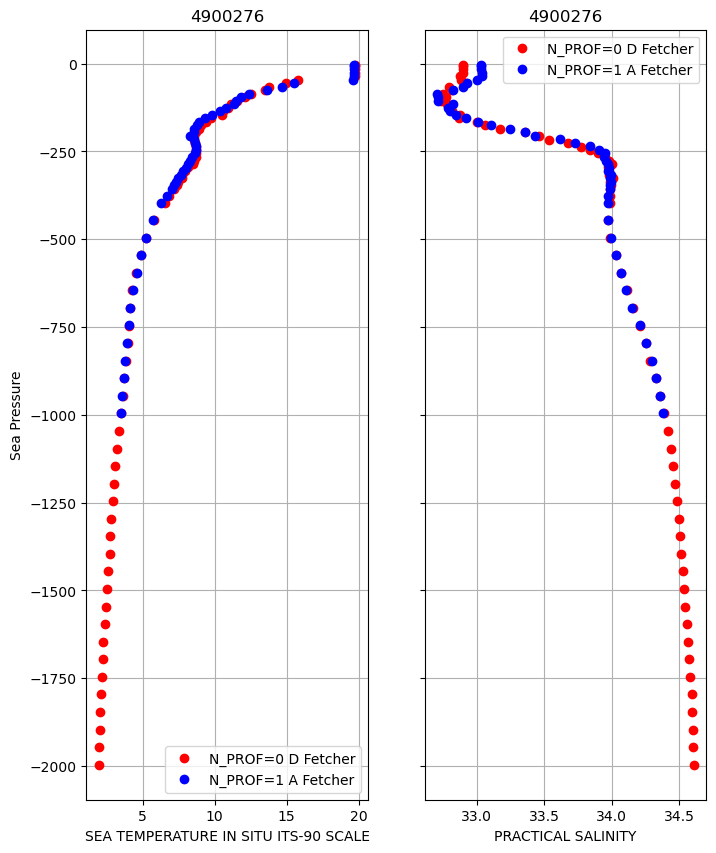

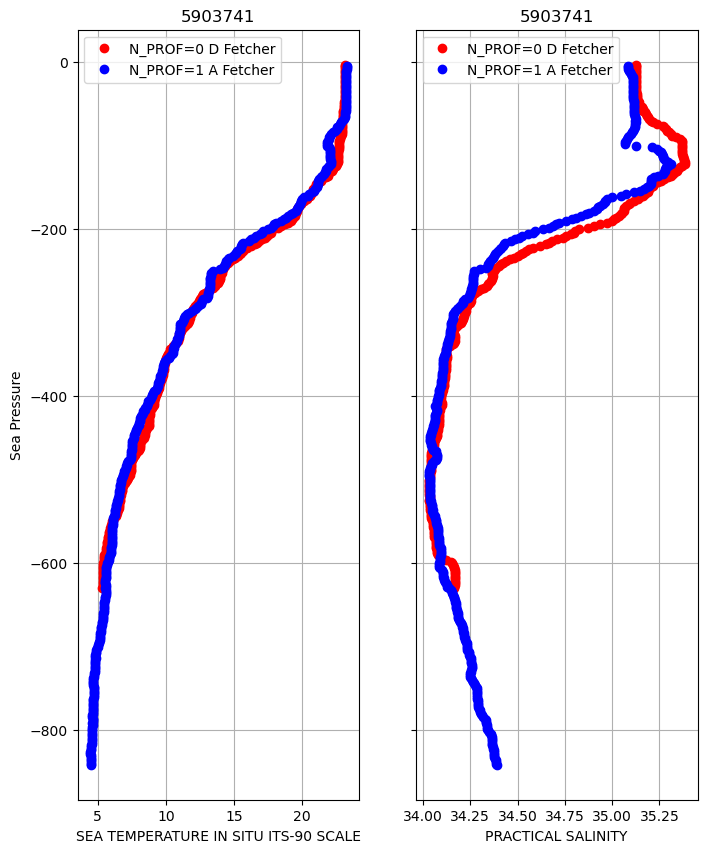

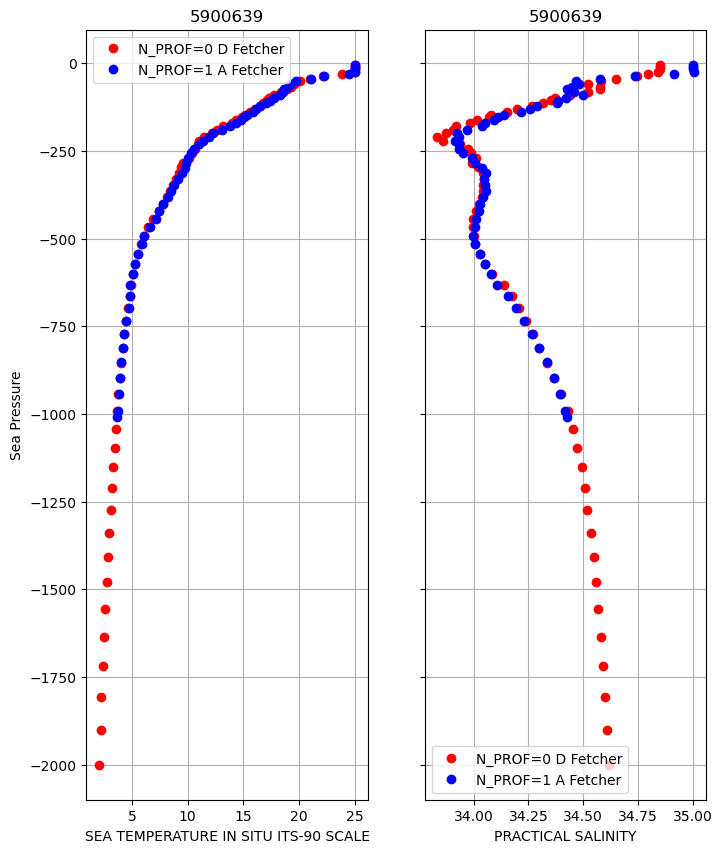

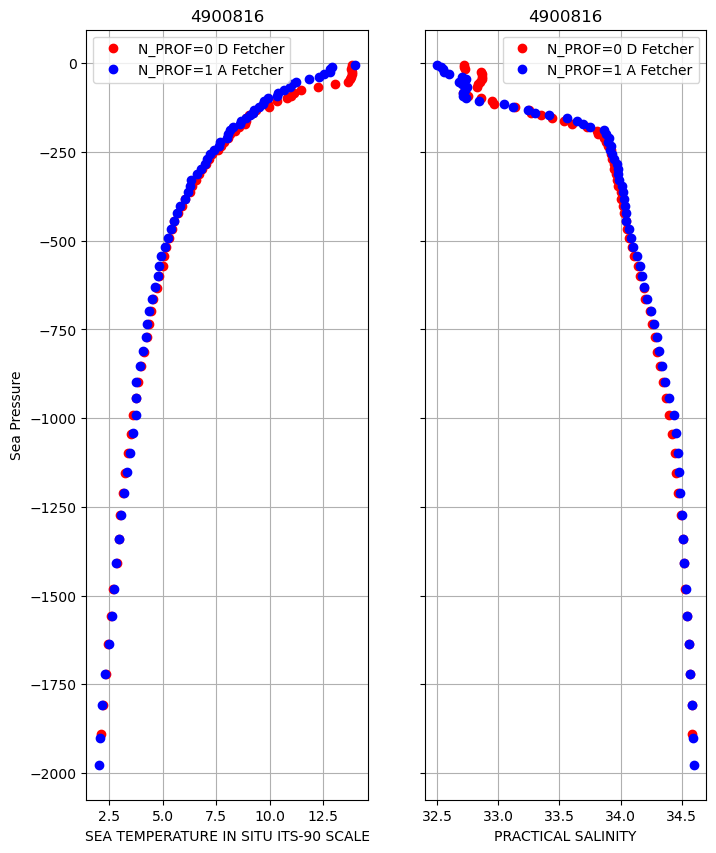

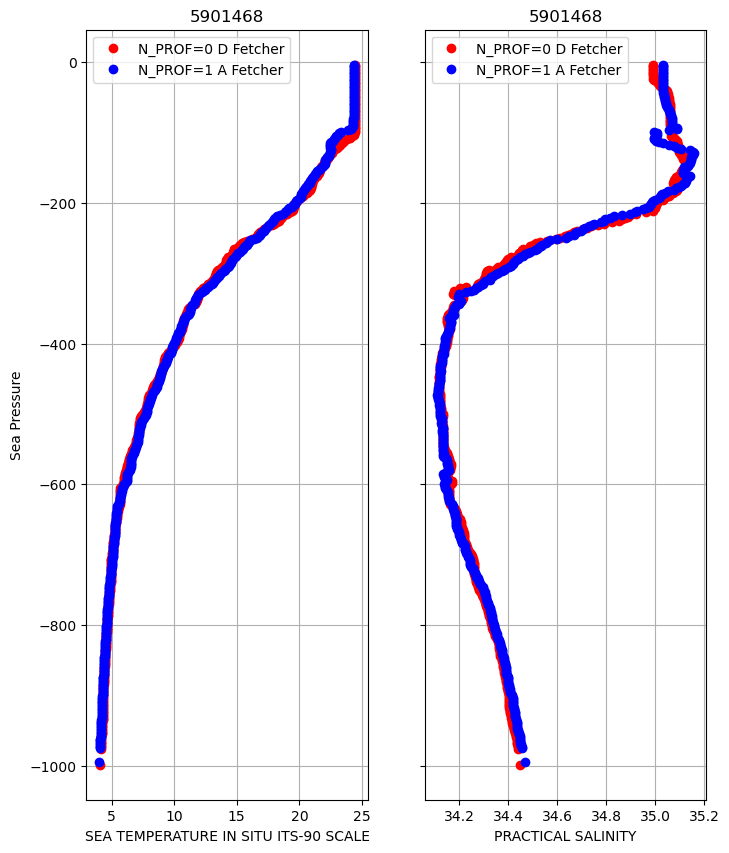

In [3]:
for a in [5906520,4900276,5903741,5900639,4900816,5901468]:
    apDS = argo_loader.float([a]).load().data
    data = apDS.argo.point2profile()
    data

    fig, ax = plt.subplots(1, 2, figsize=(8,10), sharey=True) #I believe this is only plotting the first and second profiles; do I want a plot of the average of them all?
    #Temperature
    ax[0].plot(data.TEMP[0],-data.PRES[0],'ro',label='N_PROF=0 D Fetcher')
    ax[0].plot(data.TEMP[1],-data.PRES[1],'bo',label='N_PROF=1 A Fetcher')
    ax[0].set_xlabel(data['TEMP'].attrs['long_name'])
    ax[0].set_ylabel(data['PRES'].attrs['long_name'])
    ax[0].set_title(a)
    ax[0].grid()
    ax[0].legend();
    #Salinity
    ax[1].plot(data.PSAL[0],-data.PRES[0],'ro',label='N_PROF=0 D Fetcher')
    ax[1].plot(data.PSAL[1],-data.PRES[1],'bo',label='N_PROF=1 A Fetcher')
    ax[1].set_title(a)
    ax[1].set_xlabel(data['PSAL'].attrs['long_name'])
    ax[1].grid()
    ax[1].legend();

### How to include multiple floats and their CTD graphs of ALL profiles in a given region at a given time! This was one of the graphs I focused on!

Remember, we wanted to focus on the following floats and regions in the year 2017:

Region #1:
5903608, 5904977

Region #2:
5904128, 4902149

Region #3:
4900816, 4902251

The following code does this!

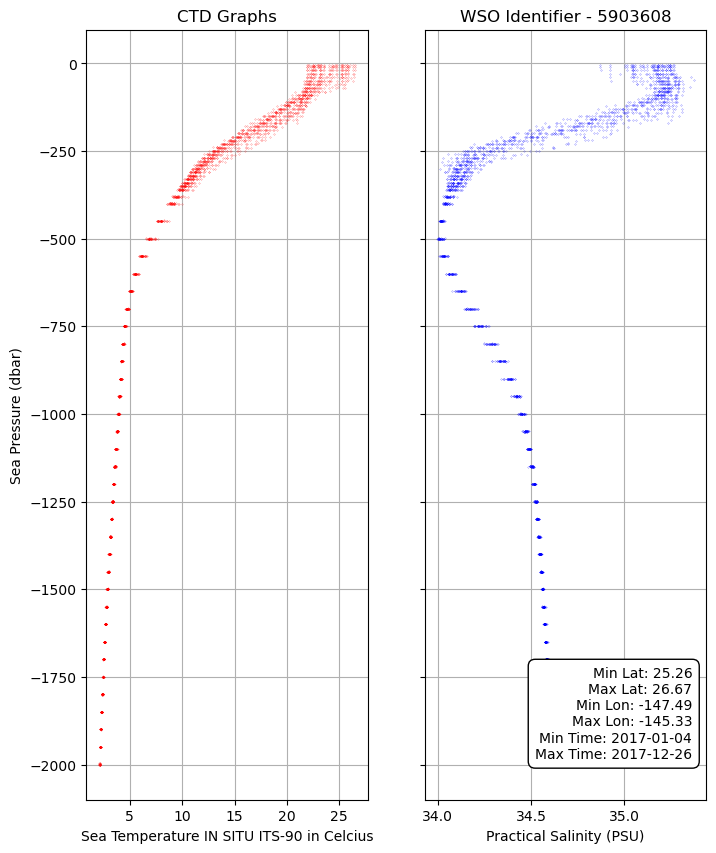

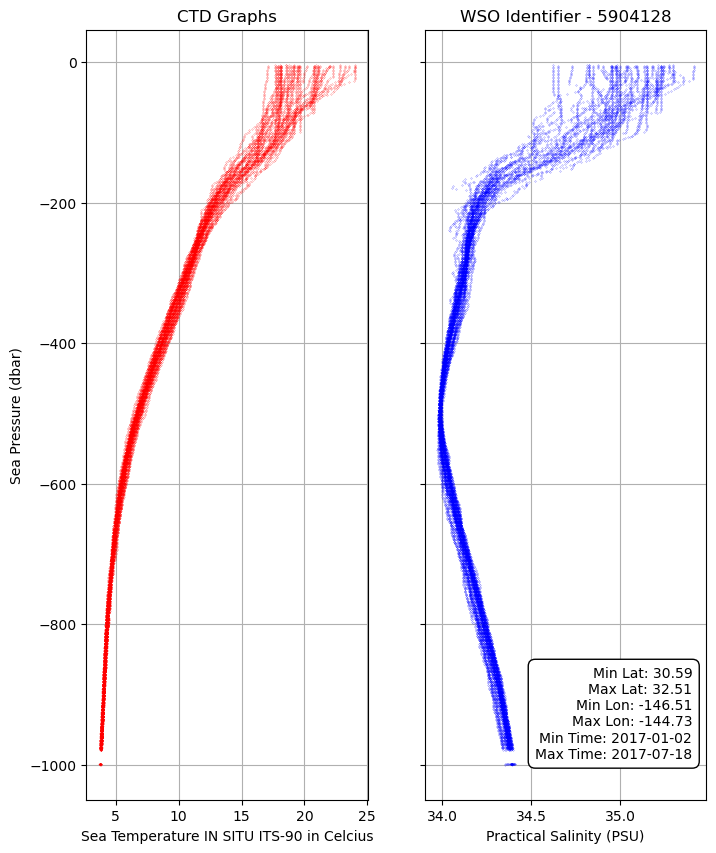

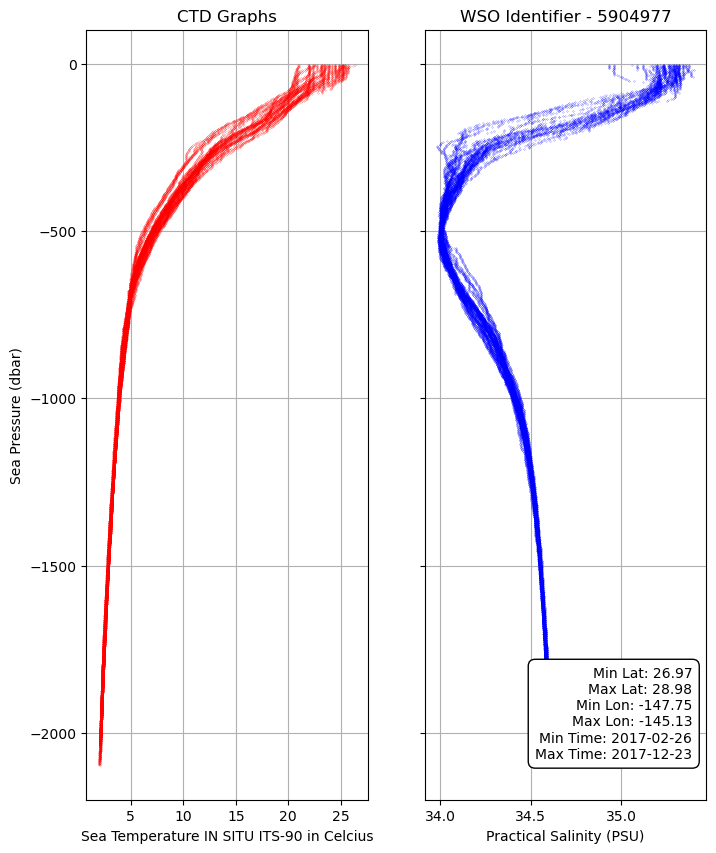

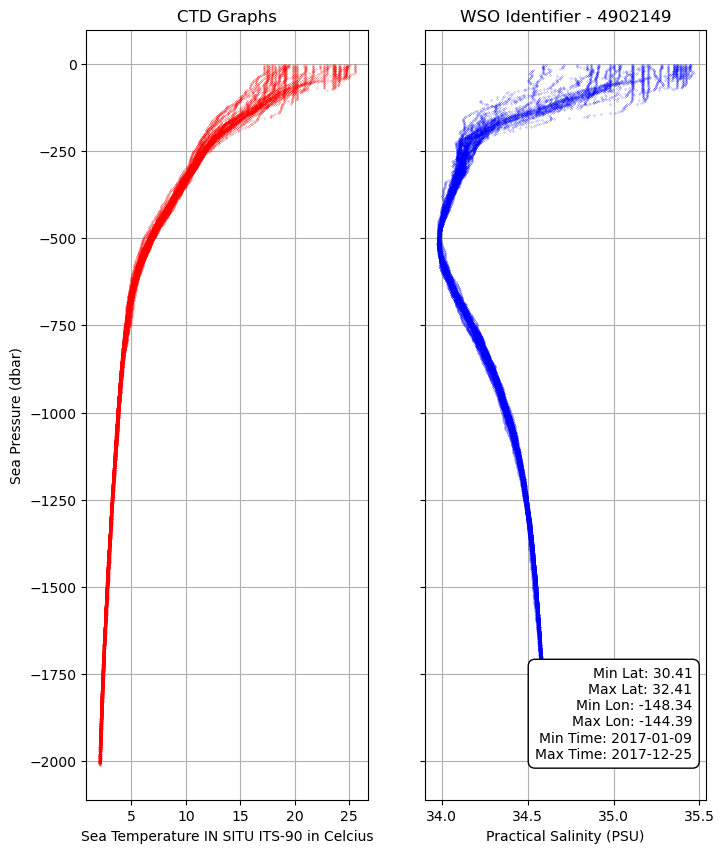

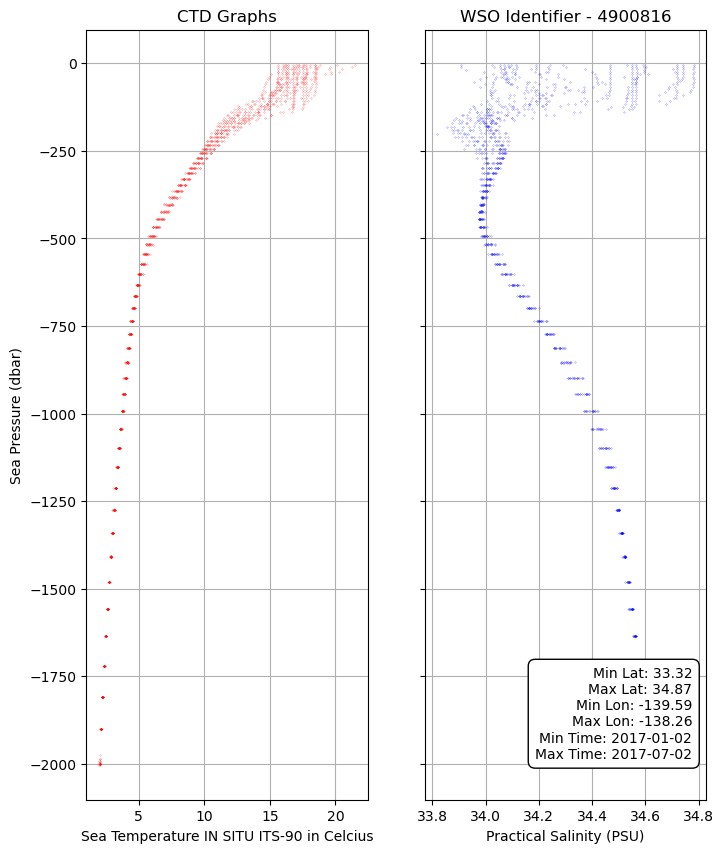

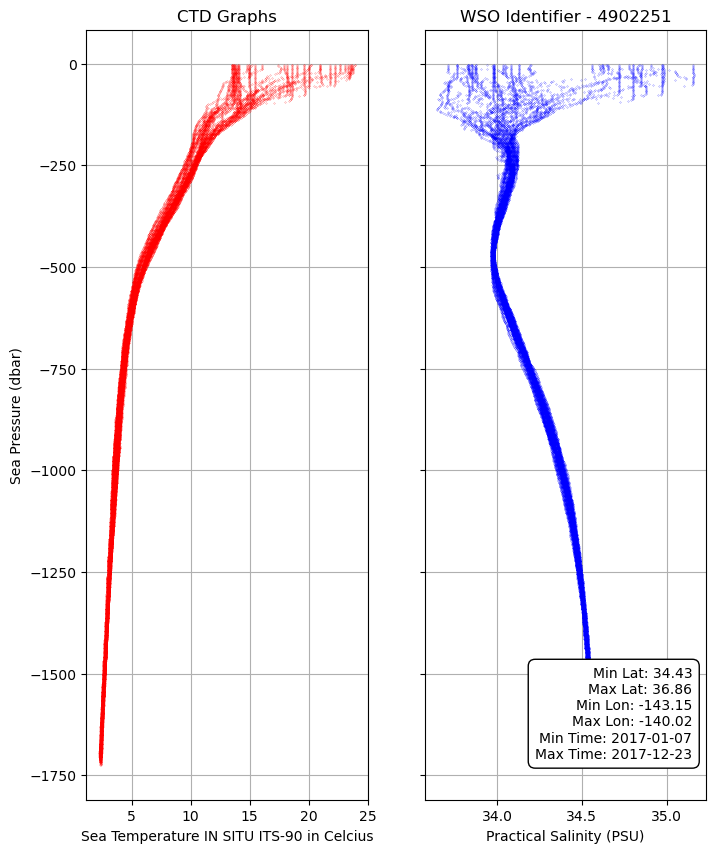

In [5]:
#This is where we slice the float data based on time stamps, in which we found the CTD data of all profiles in 2017 for all these Argo floats!

sliced_data_list = []
for a in [5903608, 5904128, 5904977, 4902149, 4900816, 4902251]:
    
    apDS = argo_loader.float(a).load().data
    data1 = apDS.argo.point2profile()
    data2 = data1.set_xindex("TIME")
    sliced_data = data2.sel(TIME=slice('2017-01-01','2017-12-31'))
    sliced_data_list.append(sliced_data)

sliced_data_dict = {}
a_values = [5903608, 5904128, 5904977, 4902149, 4900816, 4902251]
for a in a_values:
    apDS = argo_loader.float(a).load().data
    data1 = apDS.argo.point2profile()
    data2 = data1.set_xindex("TIME")
    sliced_data = data2.sel(TIME=slice('2017-01-01','2017-12-31'))
    sliced_data_dict[a] = sliced_data

import pandas as pd

for i, sliced_data in enumerate(sliced_data_list):
    
    fig, ax = plt.subplots(1, 2, figsize=(8,10), sharey=True) 

    #Calculate the max and min latitude and longitude values!
    max_lat = sliced_data.LATITUDE.max().values
    min_lat = sliced_data.LATITUDE.min().values
    max_lon = sliced_data.LONGITUDE.max().values
    min_lon = sliced_data.LONGITUDE.min().values
    min_time = pd.to_datetime(sliced_data.TIME.min().values).strftime('%Y-%m-%d')
    max_time = pd.to_datetime(sliced_data.TIME.max().values).strftime('%Y-%m-%d')


    #Calculate the number of profiles DIMENSION!
    n_prof_value = sliced_data.N_PROF.values[0]
    
    #Temperature
    ax[0].plot(sliced_data.TEMP,-sliced_data.PRES,'ro', markersize=.15)
    ax[0].set_xlabel('Sea Temperature IN SITU ITS-90 in Celcius') 
    ax[0].set_ylabel('Sea Pressure (dbar)')
    ax[0].set_title('CTD Graphs')
    ax[0].grid()
   
    #Salinity
    ax[1].plot(sliced_data.PSAL,-sliced_data.PRES,'bo', markersize=.15)
    ax[1].set_title(f"WSO Identifier - {a_values[i]}")
    ax[1].set_xlabel('Practical Salinity (PSU)')
    ax[1].grid()

    #Provide a text box with important information like lat, lon, and the number of profiles!
    text_plot = f"Min Lat: {min_lat:.2f}\nMax Lat: {max_lat:.2f}\nMin Lon: {min_lon:.2f}\nMax Lon: {max_lon:.2f}\nMin Time: {min_time}\nMax Time: {max_time}"
    ax[1].text(0.95, 0.05, text_plot, transform=ax[1].transAxes, ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

I also went ahead and individually searched for the number of profiles that each float was plotting in these graphs, the numbers of which were as follows:

1. 5903608, N_PROF = 90
2. 5904128, N_PROF = 27
3. 5904977, N_PROF = 91
4. 4902149, N_PROF = 91
5. 4902947, N_PROF = 75
6. 4902935, N_PROF = 76
7. 5903603, N_PROF = 90
8. 4903007, N_PROF = 61
9. 4900816, N_PROF = 12
10. 4902251, N_PROF = 34

Which came from simply looking at the dictionary of values created earlier:

In [6]:
sliced_data_dict

{5903608: <xarray.Dataset>
 Dimensions:          (N_PROF: 36, N_LEVELS: 71)
 Coordinates:
   * N_PROF           (N_PROF) int32 186 187 188 189 190 ... 217 218 219 220 221
   * N_LEVELS         (N_LEVELS) int32 0 1 2 3 4 5 6 7 ... 64 65 66 67 68 69 70
     LATITUDE         (N_PROF) float64 26.66 26.21 25.97 ... 25.57 25.4 25.39
     LONGITUDE        (N_PROF) float64 -146.8 -146.7 -146.7 ... -145.5 -145.3
   * TIME             (N_PROF) datetime64[ns] 2017-01-04T08:02:00 ... 2017-12-...
 Data variables: (12/15)
     CYCLE_NUMBER     (N_PROF) int32 187 188 189 190 191 ... 218 219 220 221 222
     DATA_MODE        (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D' 'D'
     DIRECTION        (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
     PLATFORM_NUMBER  (N_PROF) int32 5903608 5903608 5903608 ... 5903608 5903608
     POSITION_QC      (N_PROF) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
     PRES             (N_PROF, N_LEVELS) float32 5.5 9.6 19.4 ... 1.95e+03 nan
     .

## Different Capabilities of CTD Graphs: EM-APEX

### Creating CTD graphs like Argo but with all of EM-APEX SMILE CTD data:

Don't forget to update the paths to the correct ctd document of Argo data! But here is how I sliced the ctd data to then plot to limit my data to the SMILE experiment, and then factor out outliers at the surface so that you could better see the patterns:

### Plotting ALL EM-APEX SMILE CTD Data

First alter the EM-APEX datasets for the correct parameters:

In [7]:
EM_APEX_CTD = r"C:\Users\lily\Documents\ElizabethFiles2023\DINO SIP Documents\ctd_points_allexperiments.parquet"

EM_APEX_CTDdata_df = pd.read_parquet(EM_APEX_CTD)

EM_SMILE_df = EM_APEX_CTDdata_df.loc[EM_APEX_CTDdata_df["experiment"] == 'SMILE'] 
#EM_SMILE_df

EM_SMILE_df2 = EM_APEX_CTDdata_df.loc[(EM_APEX_CTDdata_df["experiment"] == 'SMILE') & (EM_APEX_CTDdata_df["S"] >= 33)] 
#EM_SMILE_df2

EM_SMILE_df4 = EM_APEX_CTDdata_df.loc[(EM_APEX_CTDdata_df["experiment"] == 'SMILE') & (EM_APEX_CTDdata_df["P"] >= 2)] 
#EM_SMILE_df4

EM_SMILE_df5 = EM_APEX_CTDdata_df.loc[(EM_APEX_CTDdata_df["experiment"] == 'SMILE') & (EM_APEX_CTDdata_df["P"] <= 30)] 
#EM_SMILE_df5

Then I went ahead and plotted using these parameters!

Text(0.5, 1.0, 'The CD in SMILE CTD Graph')

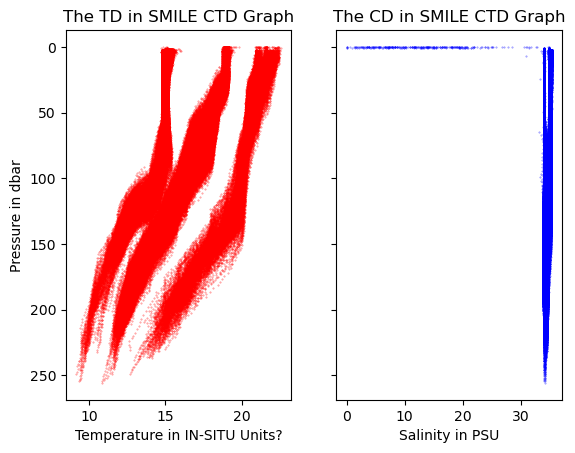

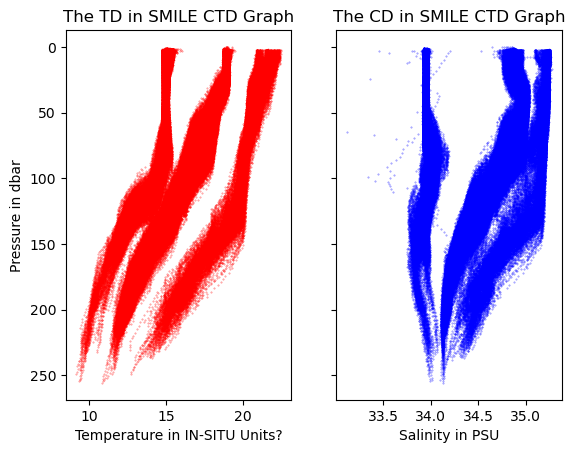

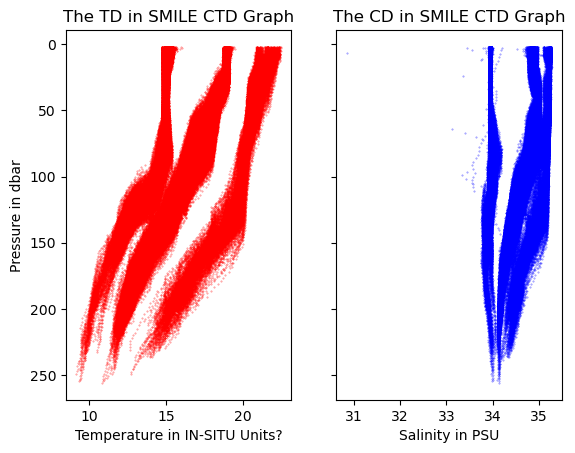

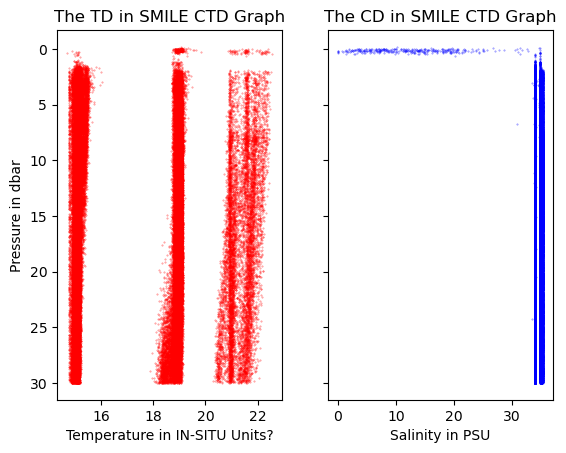

In [8]:
#Created a figure and two subplots that share a y-axis - shows ALL data without tampering for outliers.
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(EM_SMILE_df["T"], EM_SMILE_df["P"], alpha=0.5, s=.15, c='r')
ax1.invert_yaxis()
ax1.set_xlabel('Temperature in IN-SITU Units?')
ax1.set_ylabel('Pressure in dbar')
ax1.set_title('The TD in SMILE CTD Graph')

ax2.scatter(EM_SMILE_df["S"], EM_SMILE_df["P"], alpha=0.5, s=.15, c='b')
plt.gca().invert_yaxis()
ax2.set_xlabel('Salinity in PSU')
ax2.invert_yaxis()
ax2.set_title('The CD in SMILE CTD Graph')

#Created a figure and two subplots that share a y-axis - shows ALL data w/ salinities greater than 33
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(EM_SMILE_df2["T"], EM_SMILE_df2["P"], alpha=0.5, s=.15, c='r')
ax1.invert_yaxis()
ax1.set_xlabel('Temperature in IN-SITU Units?')
ax1.set_ylabel('Pressure in dbar')
ax1.set_title('The TD in SMILE CTD Graph')

ax2.scatter(EM_SMILE_df2["S"], EM_SMILE_df2["P"], alpha=0.5, s=.15, c='b')
plt.gca().invert_yaxis()
ax2.set_xlabel('Salinity in PSU')
ax2.invert_yaxis()
ax2.set_title('The CD in SMILE CTD Graph')

#Created a figure and two subplots that share a y-axis - shows ALL data w/ pressures greater than 2!
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(EM_SMILE_df4["T"], EM_SMILE_df4["P"], alpha=0.5, s=.15, c='r')
ax1.invert_yaxis()
ax1.set_xlabel('Temperature in IN-SITU Units?')
ax1.set_ylabel('Pressure in dbar')
ax1.set_title('The TD in SMILE CTD Graph')

ax2.scatter(EM_SMILE_df4["S"], EM_SMILE_df4["P"], alpha=0.5, s=.15, c='b')
plt.gca().invert_yaxis()
ax2.set_xlabel('Salinity in PSU')
ax2.invert_yaxis()
ax2.set_title('The CD in SMILE CTD Graph')

#Created a figure and two subplots that share a y-axis - shows ALL data w/ pressures less than 30!
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(EM_SMILE_df5["T"], EM_SMILE_df5["P"], alpha=0.5, s=.15, c='r')
ax1.invert_yaxis()
ax1.set_xlabel('Temperature in IN-SITU Units?')
ax1.set_ylabel('Pressure in dbar')
ax1.set_title('The TD in SMILE CTD Graph')

ax2.scatter(EM_SMILE_df5["S"], EM_SMILE_df5["P"], alpha=0.5, s=.15, c='b')
plt.gca().invert_yaxis()
ax2.set_xlabel('Salinity in PSU')
ax2.invert_yaxis()
ax2.set_title('The CD in SMILE CTD Graph')

### Plotting all CTD graphs by Region!

Then I went ahead and split the CTD data up into geographical regions (do note this did not filter out value outliers that were beyond 2017): 

First filter for the proper parameters:

In [9]:
Section_1 = ["4968s1", "4970s1", "6669s1", "6677s1", "6680s1", "7493s1", "7495s1", "7805s1", "7805s1a", "7806s1"]

Section_2 = ["4392s2", "4968s2", "4970s2", "6668s2", "6669s2", "6670s2", "6677s2", "6679s2", "6680s2", "7493s2", "7494s2", "7495s2", "7800s2", "7802s2", "7804s2", "7805s2", "7806s2"]

Section_3 = ["4392s3", "4968s3", "4970s3", "6665s3", "6668s3", "6669s3", "6670s3", "6673s3", "6676s3", "6677s3", "6679s3", "7494s3", "7493s3", "7800s3", "7801s3", "7802s3", "7803s3", "7804s3", "7805s3", "7806s3", "7807s3", "7808s3"]

EM_SMILE_dfR1 = EM_APEX_CTDdata_df.loc[(EM_APEX_CTDdata_df['deployment'].isin(Section_1)) & (EM_APEX_CTDdata_df["S"] >= 33)] 
#EM_SMILE_df1 represents region #1 of EM-APEX data, with salinity greater than 33 to get rid of surface outliers.

EM_SMILE_dfR2 = EM_APEX_CTDdata_df.loc[(EM_APEX_CTDdata_df['deployment'].isin(Section_2)) & (EM_APEX_CTDdata_df["S"] >= 33)] 
#EM_SMILE_df2 represents region #2 of EM-APEX data, with salinity greater than 33 to get rid of surface outliers.

EM_SMILE_dfR3 = EM_APEX_CTDdata_df.loc[(EM_APEX_CTDdata_df['deployment'].isin(Section_3)) & (EM_APEX_CTDdata_df["S"] >= 33)] 
#EM_SMILE_df3 represents region #3 of EM-APEX data, with salinity greater than 33 to get rid of surface outliers.

Then graph the new filtered CTD dataset for each region representing all EM-APEX SMILE data!

Text(0.5, 1.0, 'The CD in SMILE CTD Graph')

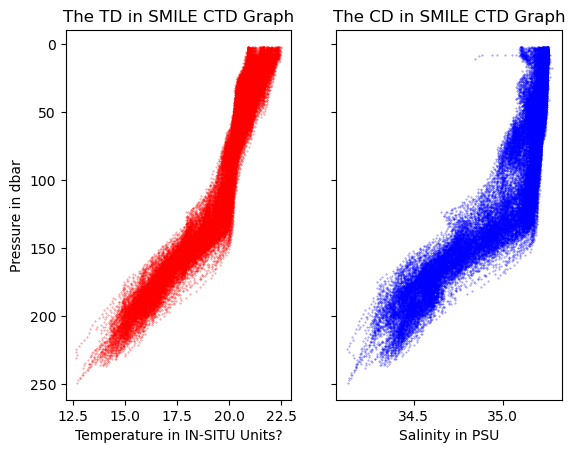

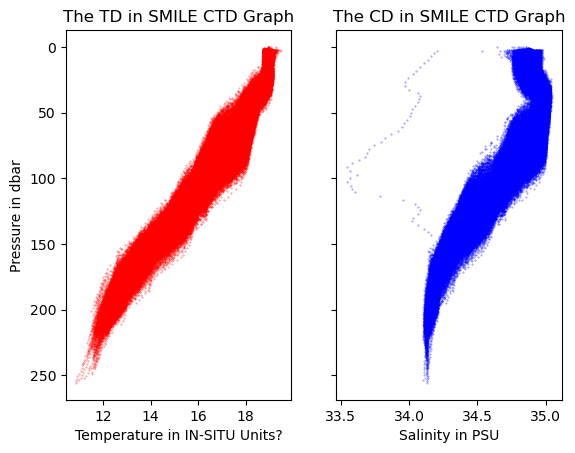

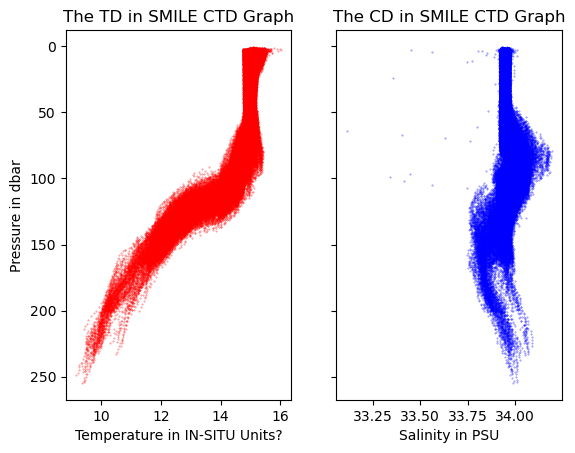

In [10]:
#Created a figure and two subplots that share a y-axis - shows ALL data in Region 1 of EM-APEX floats in SMILE experiment w/ salinities greater than 33
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(EM_SMILE_dfR1["T"], EM_SMILE_dfR1["P"], alpha=0.5, s=.15, c='r')
ax1.invert_yaxis()
ax1.set_xlabel('Temperature in IN-SITU Units?')
ax1.set_ylabel('Pressure in dbar')
ax1.set_title('The TD in SMILE CTD Graph')

ax2.scatter(EM_SMILE_dfR1["S"], EM_SMILE_dfR1["P"], alpha=0.5, s=.15, c='b')
plt.gca().invert_yaxis()
ax2.set_xlabel('Salinity in PSU')
ax2.invert_yaxis()
ax2.set_title('The CD in SMILE CTD Graph')

#Created a figure and two subplots that share a y-axis - shows ALL data in Region 2 of EM-APEX floats in SMILE experiment w/ salinities greater than 33
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(EM_SMILE_dfR2["T"], EM_SMILE_dfR2["P"], alpha=0.5, s=.15, c='r')
ax1.invert_yaxis()
ax1.set_xlabel('Temperature in IN-SITU Units?')
ax1.set_ylabel('Pressure in dbar')
ax1.set_title('The TD in SMILE CTD Graph')

ax2.scatter(EM_SMILE_dfR2["S"], EM_SMILE_dfR2["P"], alpha=0.5, s=.15, c='b')
plt.gca().invert_yaxis()
ax2.set_xlabel('Salinity in PSU')
ax2.invert_yaxis()
ax2.set_title('The CD in SMILE CTD Graph')

#Created a figure and two subplots that share a y-axis - shows ALL data in Region 3 of EM-APEX floats in SMILE experiment w/ salinities greater than 33
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(EM_SMILE_dfR3["T"], EM_SMILE_dfR3["P"], alpha=0.5, s=.15, c='r')
ax1.invert_yaxis()
ax1.set_xlabel('Temperature in IN-SITU Units?')
ax1.set_ylabel('Pressure in dbar')
ax1.set_title('The TD in SMILE CTD Graph')

ax2.scatter(EM_SMILE_dfR3["S"], EM_SMILE_dfR3["P"], alpha=0.5, s=.15, c='b')
plt.gca().invert_yaxis()
ax2.set_xlabel('Salinity in PSU')
ax2.invert_yaxis()
ax2.set_title('The CD in SMILE CTD Graph')

## Project Goal - Seasonal Variations (How to split Argo 2017 data into months!)

Plotting all Argo float data that is within 2017 and intersect geographical bounds of Region 1, 2, and 3, but instead of compiled this includes by month. I was not able to do this all at once, but for the poster I was able to individually plot two floats month by month with no errors.

Again, recall which floats were identified to match which regions:

Region #1:
5903608, 5904977

Region #2:
5904128, 4902149

Region #3:
4900816, 4902251

### Two Argo Floats CTD Monthly Data Featured on Poster/Paper

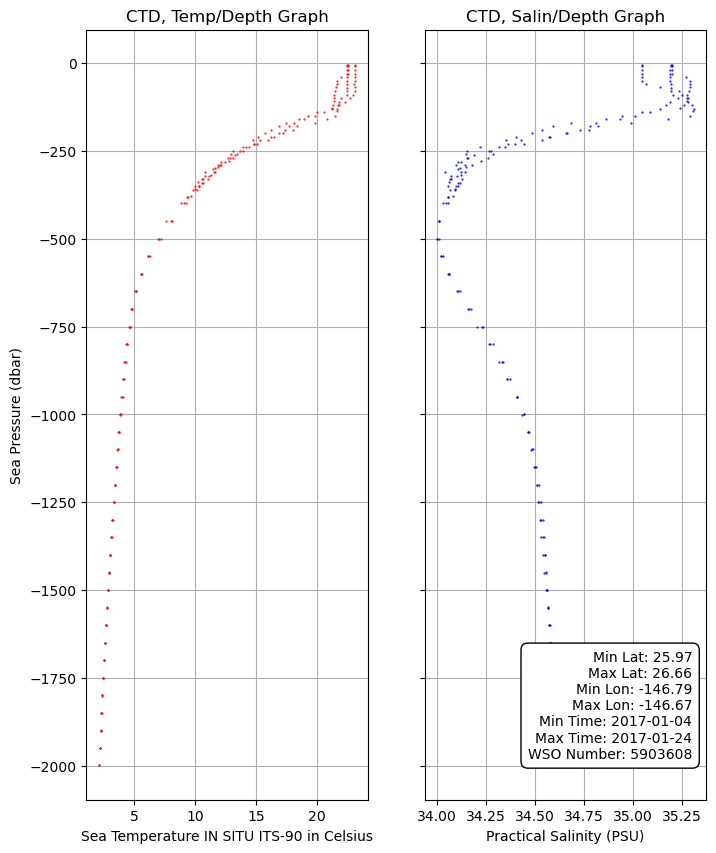

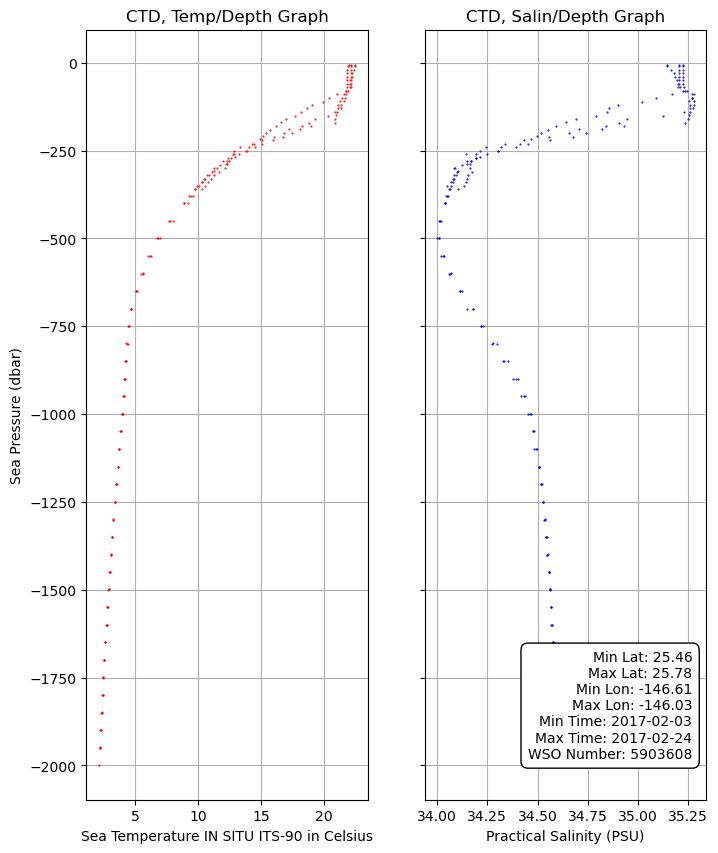

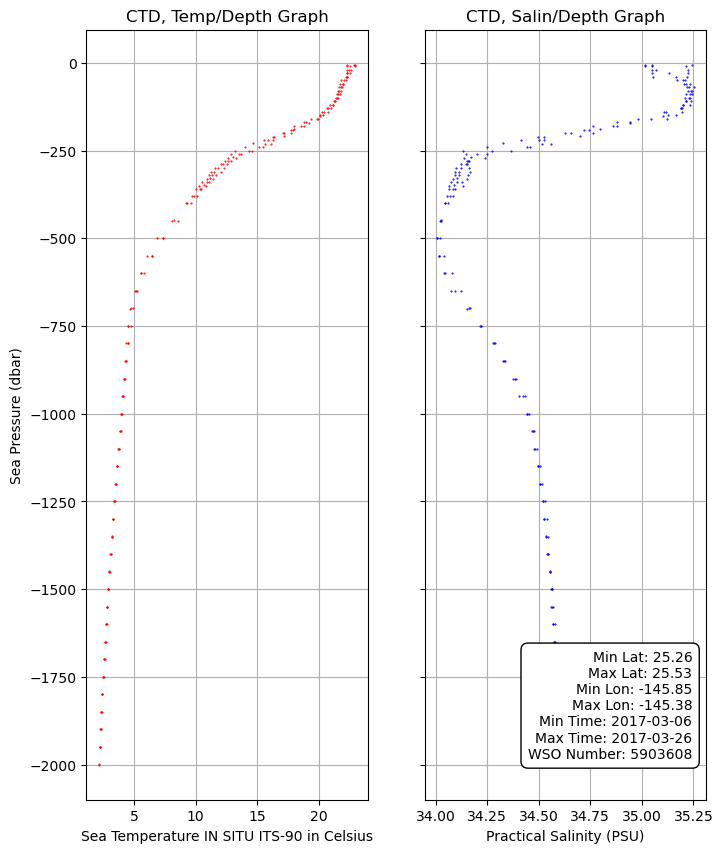

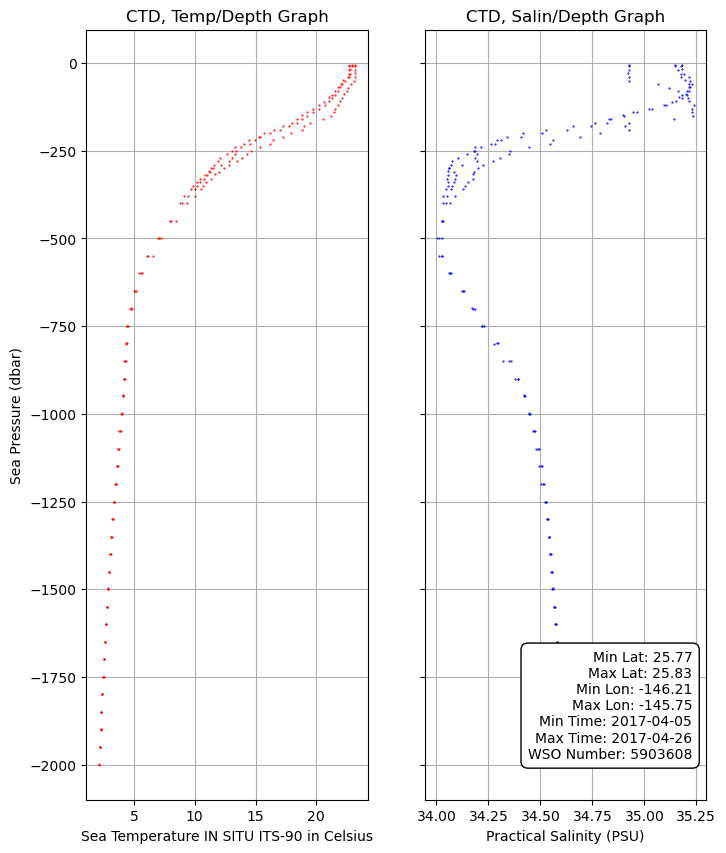

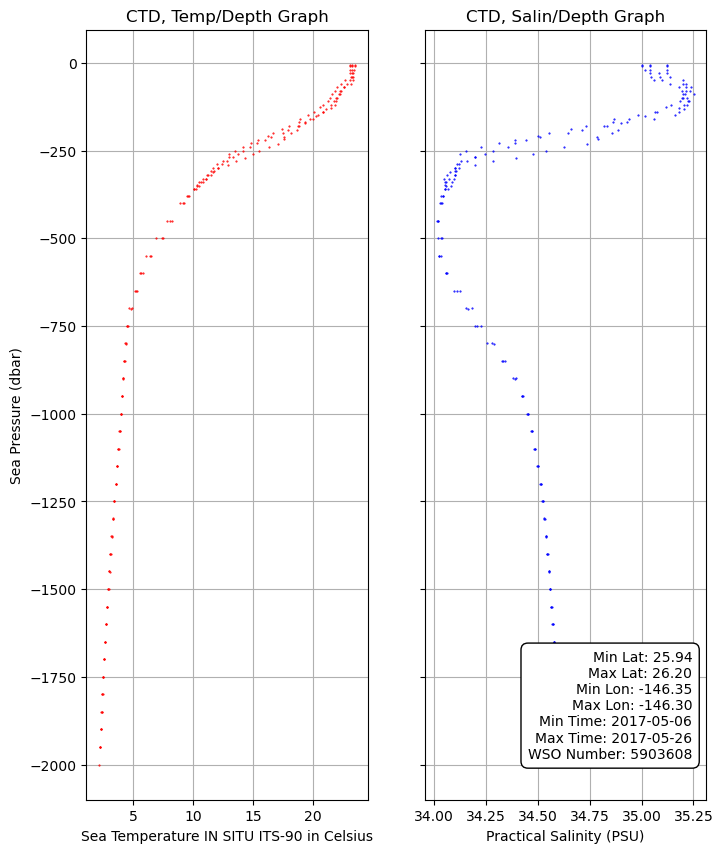

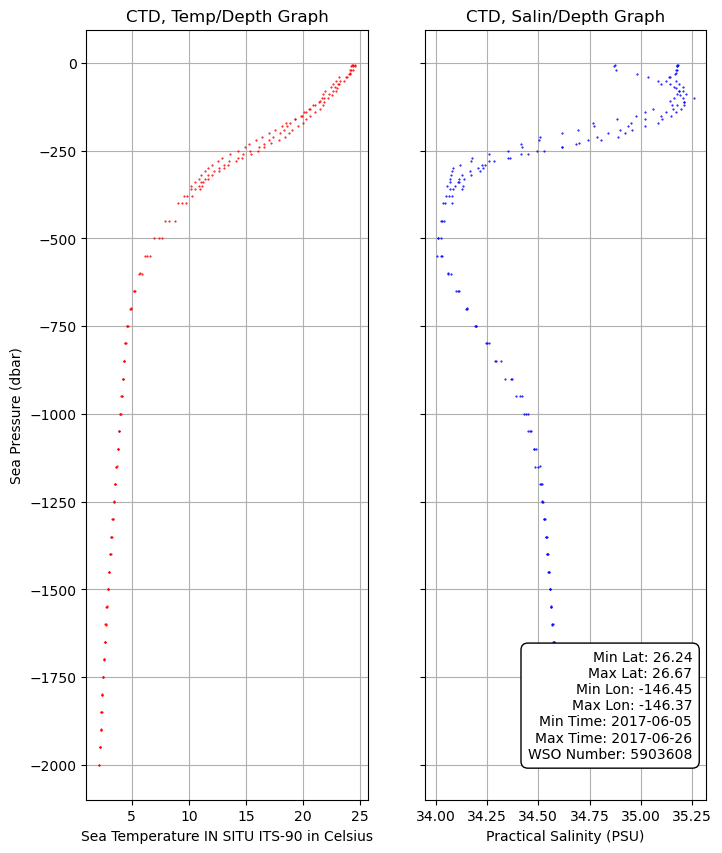

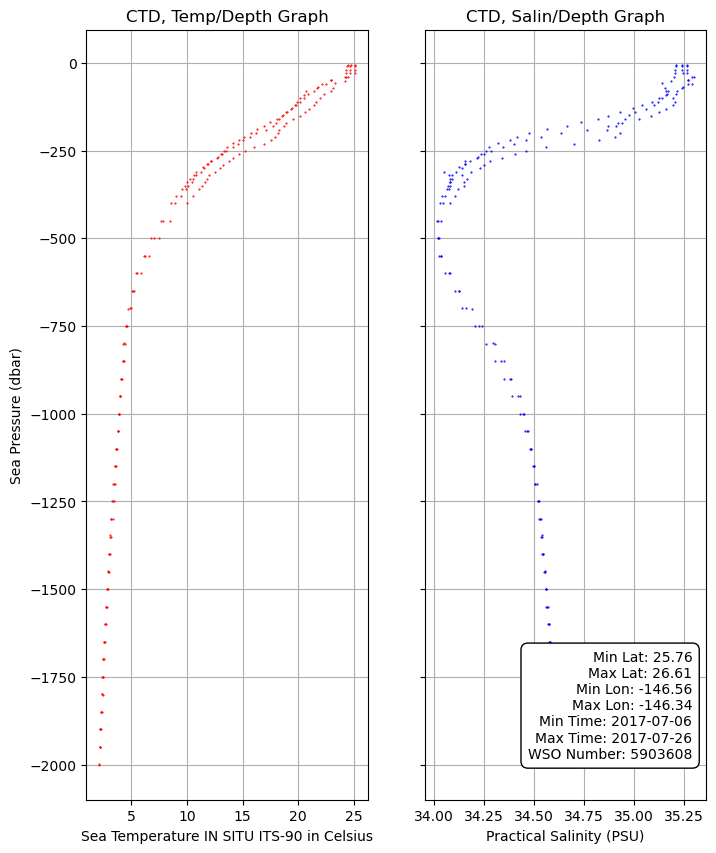

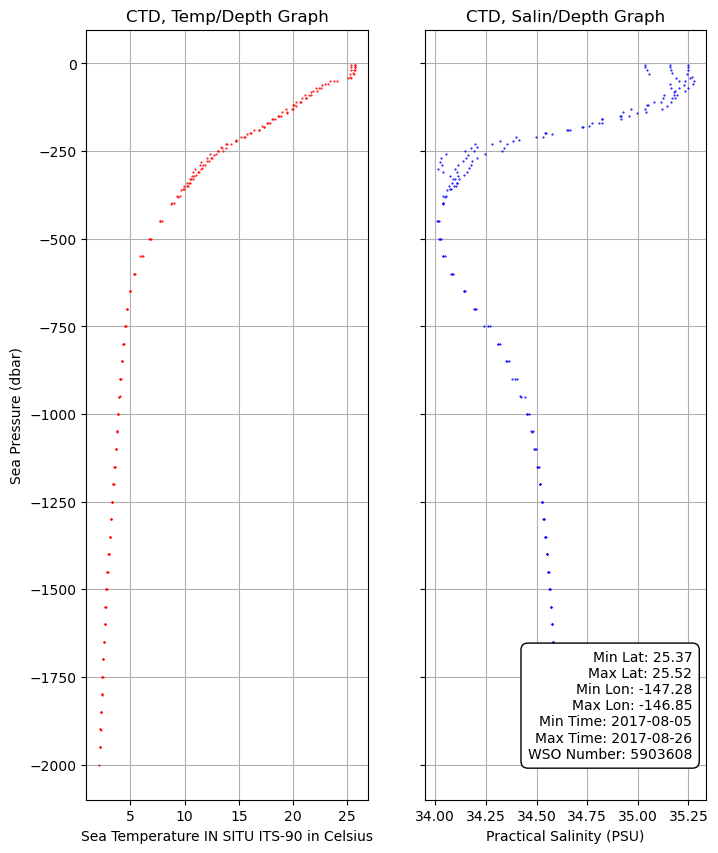

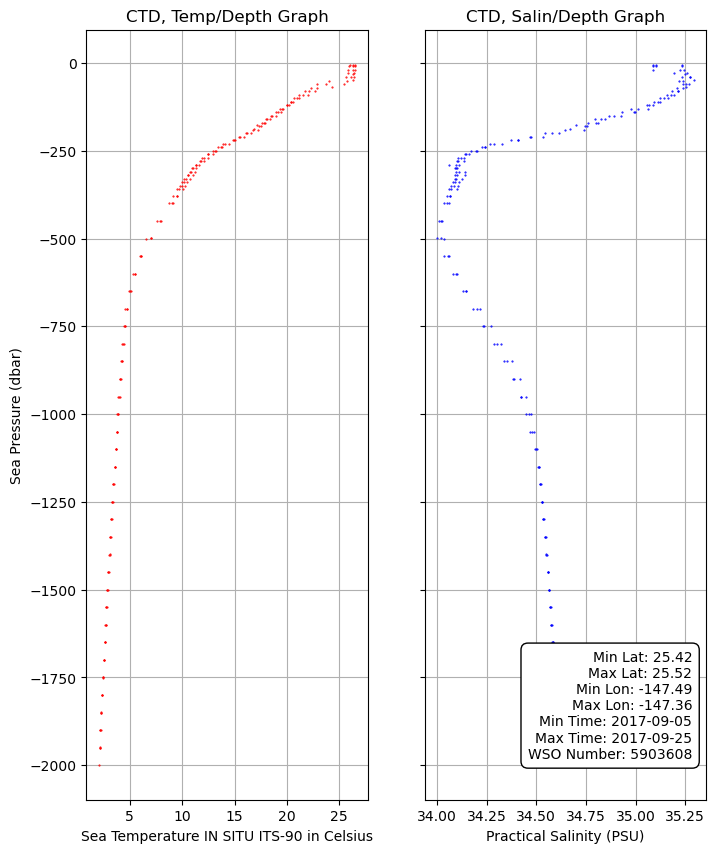

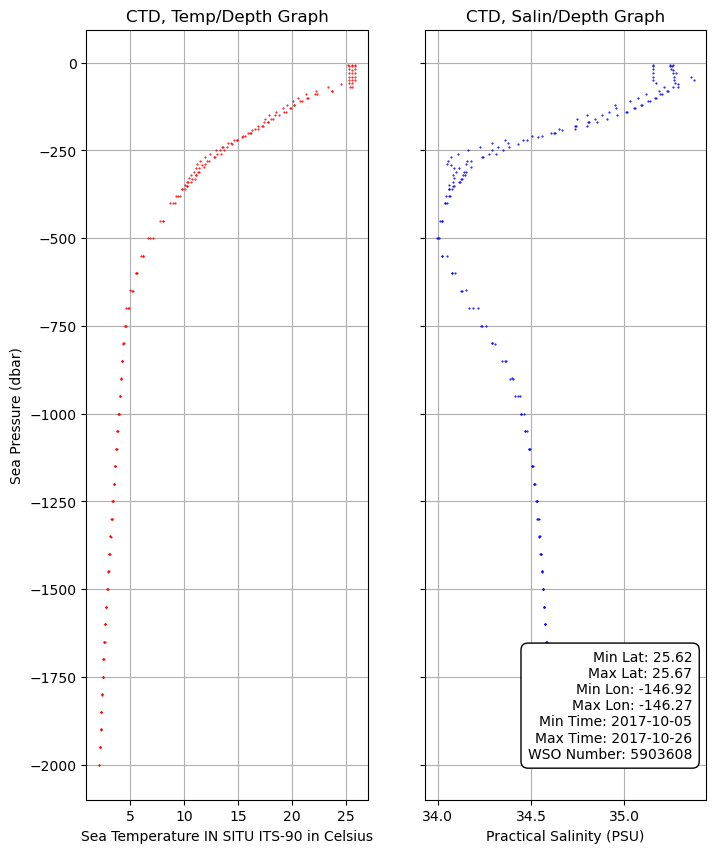

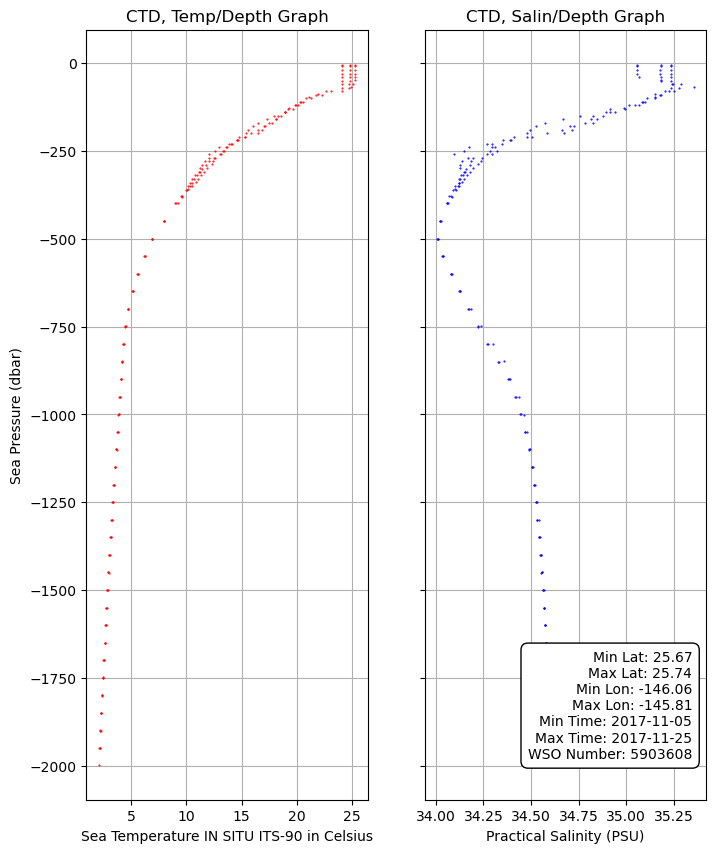

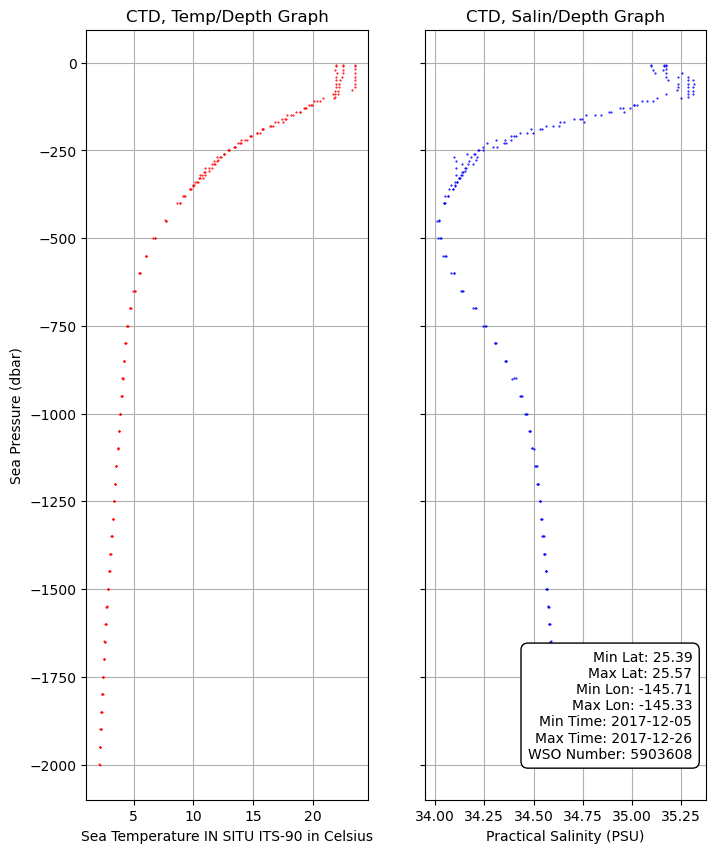

In [13]:
### Focus Region 1 for Poster - Float 5903608 - CTD Monthly data!!
import numpy as np
import matplotlib.pyplot as plt

sliced_data_list = []

a_values = [5903608]
n_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for a in a_values:
    apDS = argo_loader.float(a).load().data
    data1 = apDS.argo.point2profile()
    data2 = data1.set_xindex("TIME")
    sliced_data = data2.sel(TIME=slice('2017-01-01', '2017-12-31'))
    
    for n in n_values:
        # Corrected the slice() function
        sliced_data_month = sliced_data.sel(TIME=sliced_data.TIME.dt.month == n)
        
        # Skip zero-size arrays
        #if sliced_data_month.isnull().any():  # Skip if any NaN values are present
            #continue
        
        sliced_data_list.append(sliced_data_month)


def plot_graph_and_text(ax, sliced_data, a_values):
    
    # Calculate the max and min latitude and longitude values!
    max_lat = sliced_data.LATITUDE.max().values
    min_lat = sliced_data.LATITUDE.min().values
    max_lon = sliced_data.LONGITUDE.max().values
    min_lon = sliced_data.LONGITUDE.min().values
    min_time = pd.to_datetime(sliced_data.TIME.min().values).strftime('%Y-%m-%d')
    max_time = pd.to_datetime(sliced_data.TIME.max().values).strftime('%Y-%m-%d')
    wso_identifier = sliced_data.PLATFORM_NUMBER.min().values

    # Calculate the number of profiles DIMENSION!
    n_prof_value = sliced_data.N_PROF.values[0]

    # Temperature
    ax[0].plot(sliced_data.TEMP, -sliced_data.PRES, 'ro', markersize= .5)
    ax[0].set_xlabel('Sea Temperature IN SITU ITS-90 in Celsius')
    ax[0].set_ylabel('Sea Pressure (dbar)')
    ax[0].set_title('CTD, Temp/Depth Graph')
    ax[0].grid()

    # Salinity
    ax[1].plot(sliced_data.PSAL, -sliced_data.PRES, 'bo', markersize= .5)
    ax[1].set_title('CTD, Salin/Depth Graph')
    ax[1].set_xlabel('Practical Salinity (PSU)')
    ax[1].grid()

    # Provide a text box with important information like lat, lon, and the number of profiles!
    text_plot = f"Min Lat: {min_lat:.2f}\nMax Lat: {max_lat:.2f}\nMin Lon: {min_lon:.2f}\nMax Lon: {max_lon:.2f}\nMin Time: {min_time}\nMax Time: {max_time}\nWSO Number: {wso_identifier}"
    ax[1].text(0.95, 0.05, text_plot, transform=ax[1].transAxes, ha='right', va='bottom', fontsize=10,
               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        
for a in a_values:
    apDS = argo_loader.float(a).load().data
    data1 = apDS.argo.point2profile()
    data2 = data1.set_xindex("TIME")

for i, sliced_data in enumerate(sliced_data_list):
    fig, ax = plt.subplots(1, 2, figsize=(8, 10), sharey=True)
    plot_graph_and_text(ax, sliced_data, a_values)

plt.show()  # Add this to display all the plots together

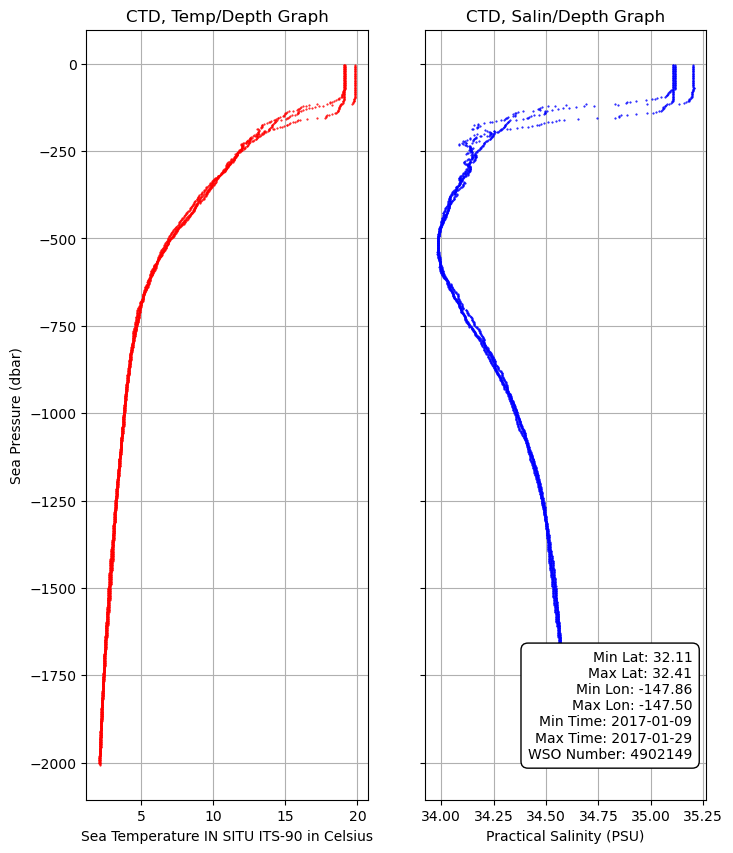

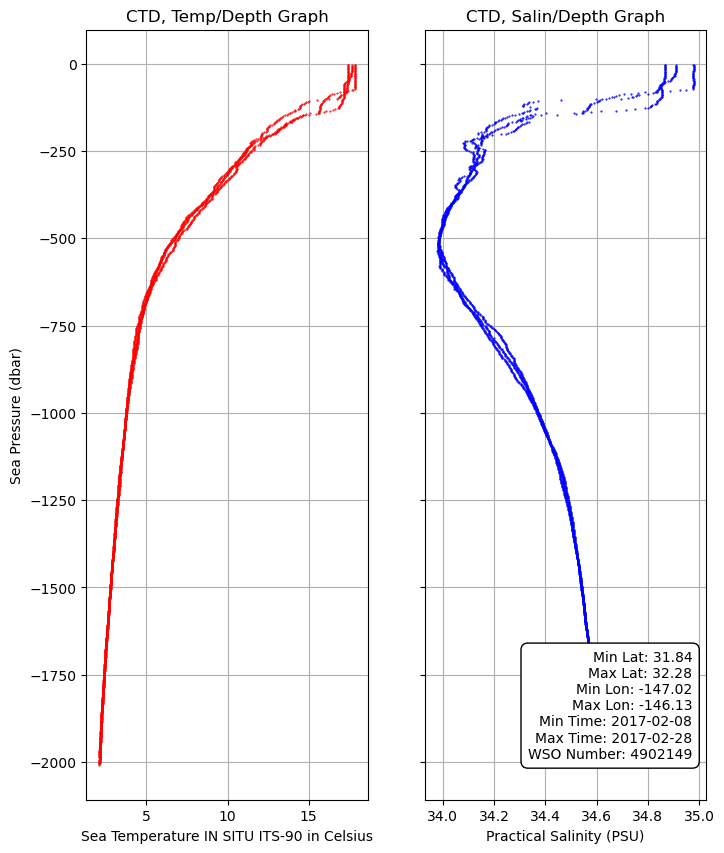

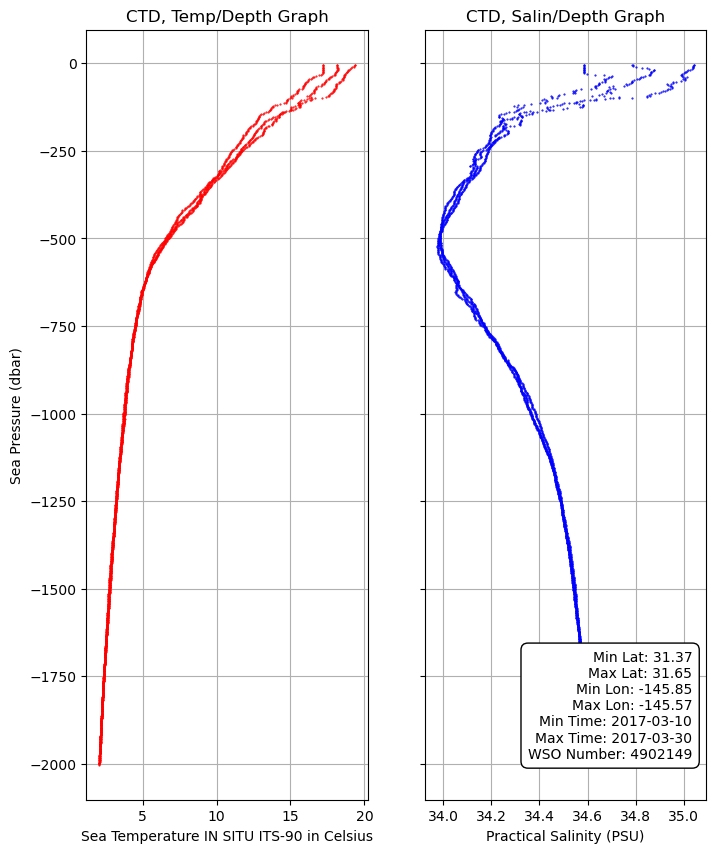

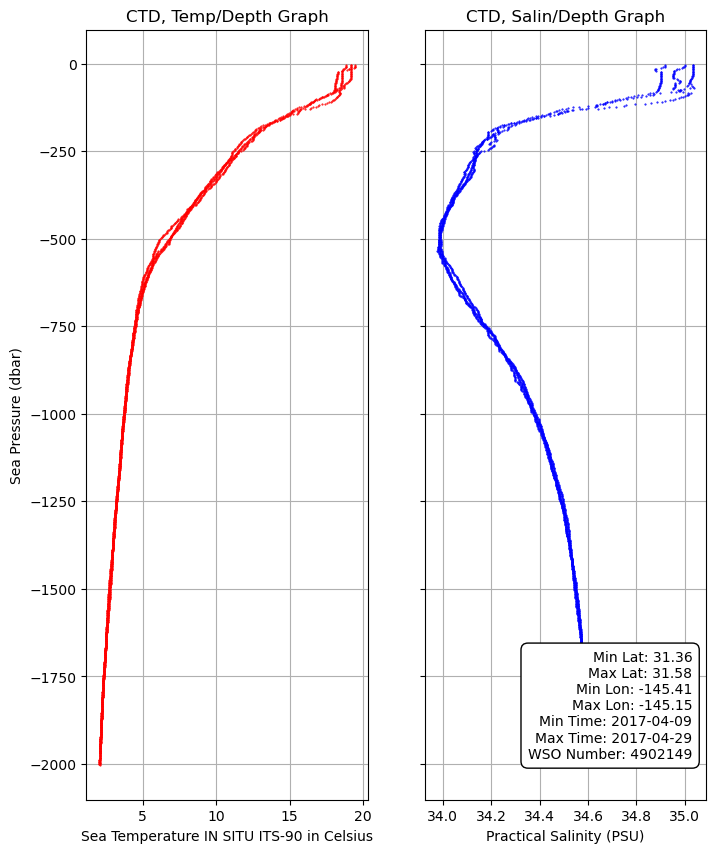

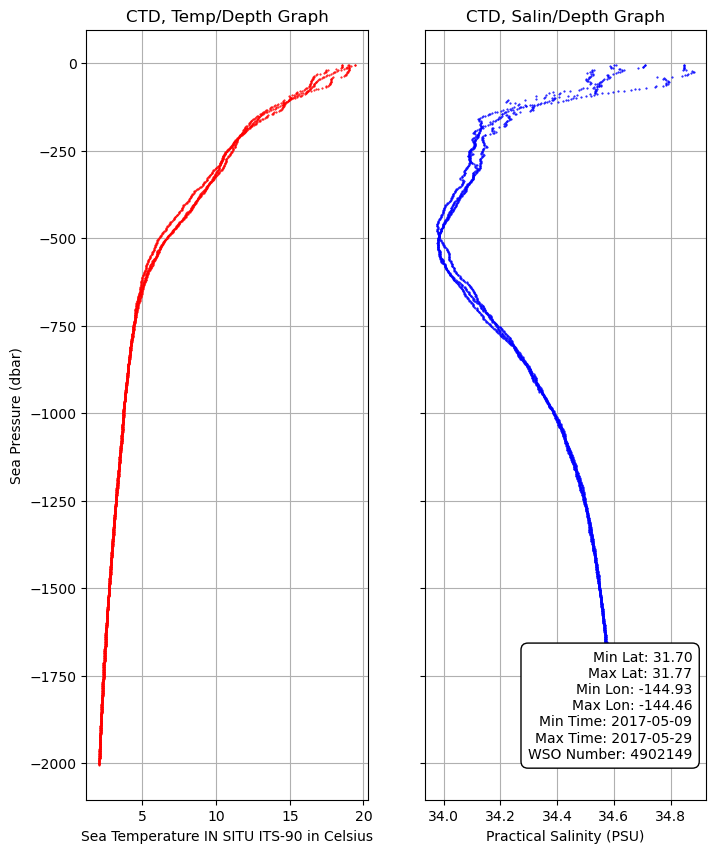

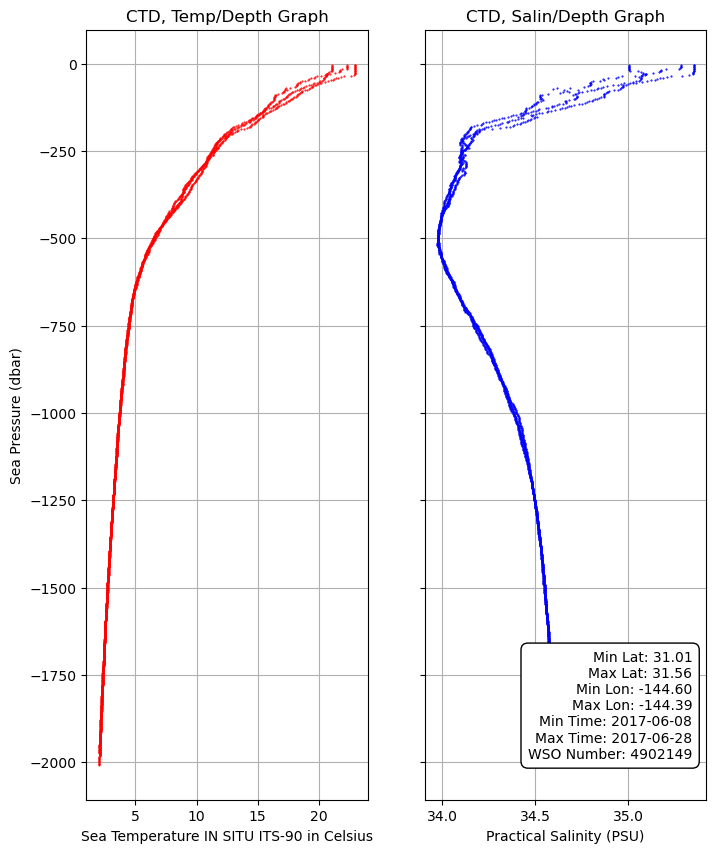

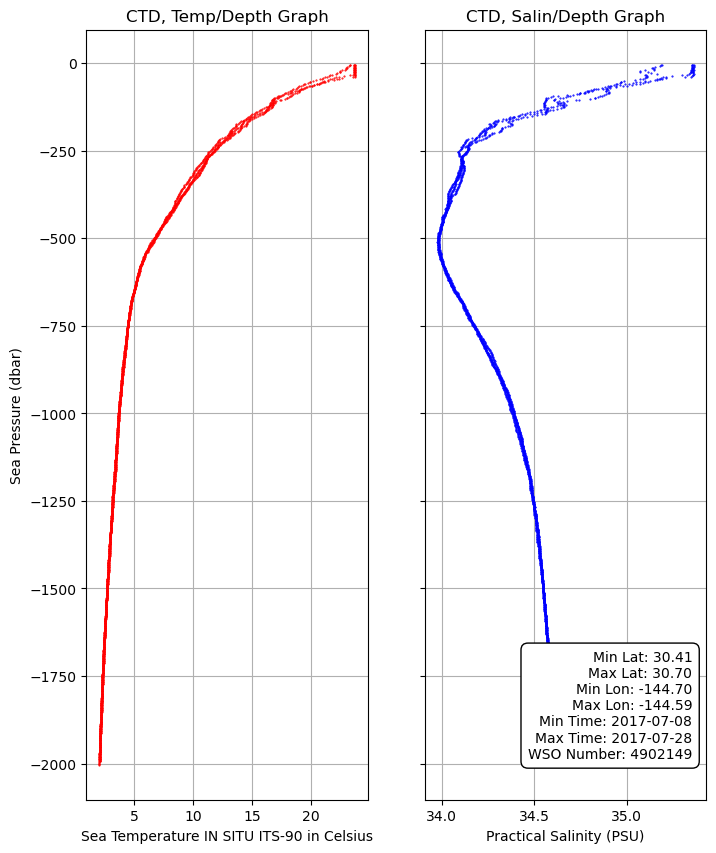

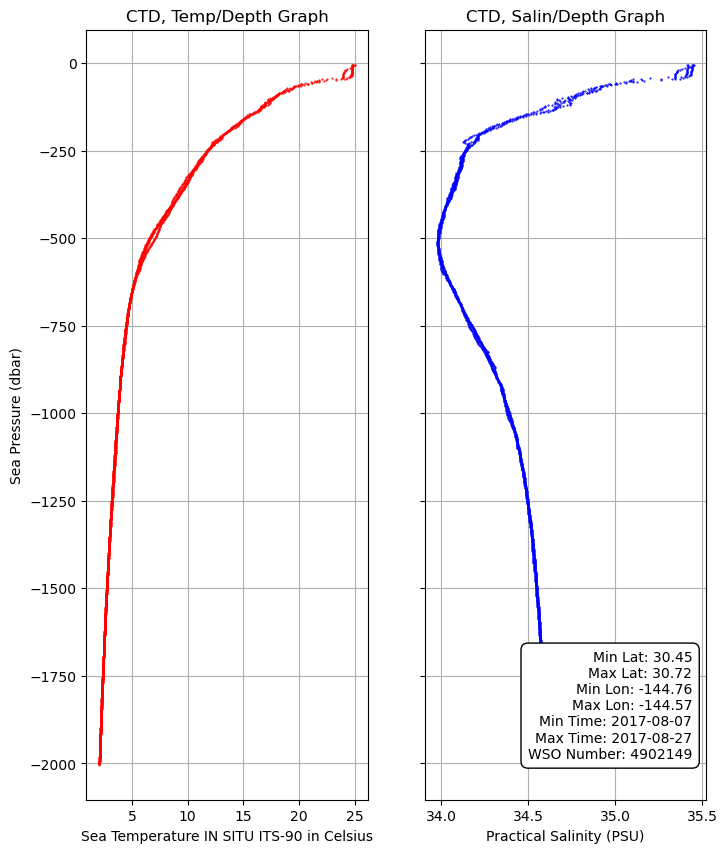

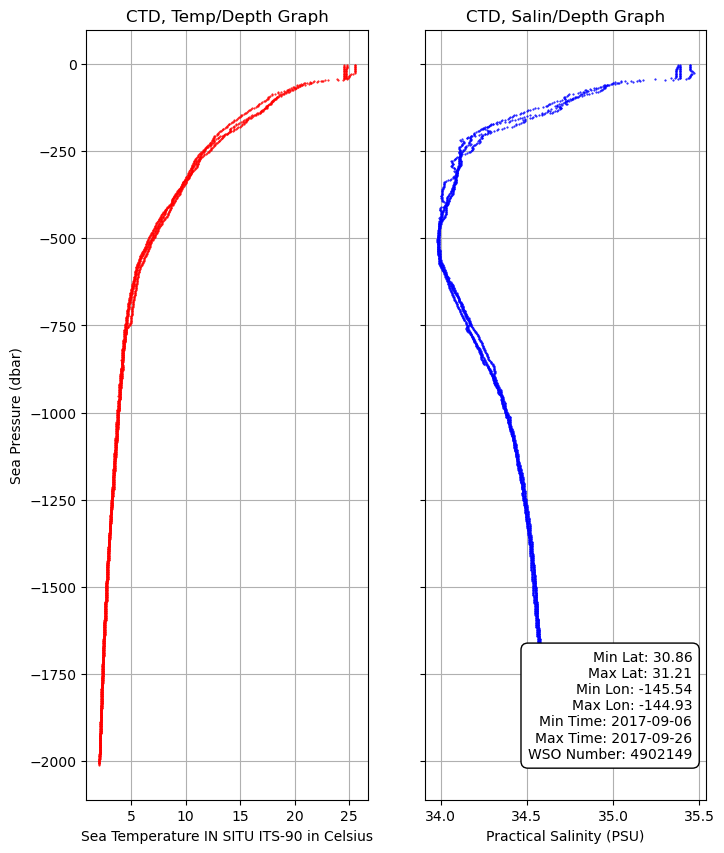

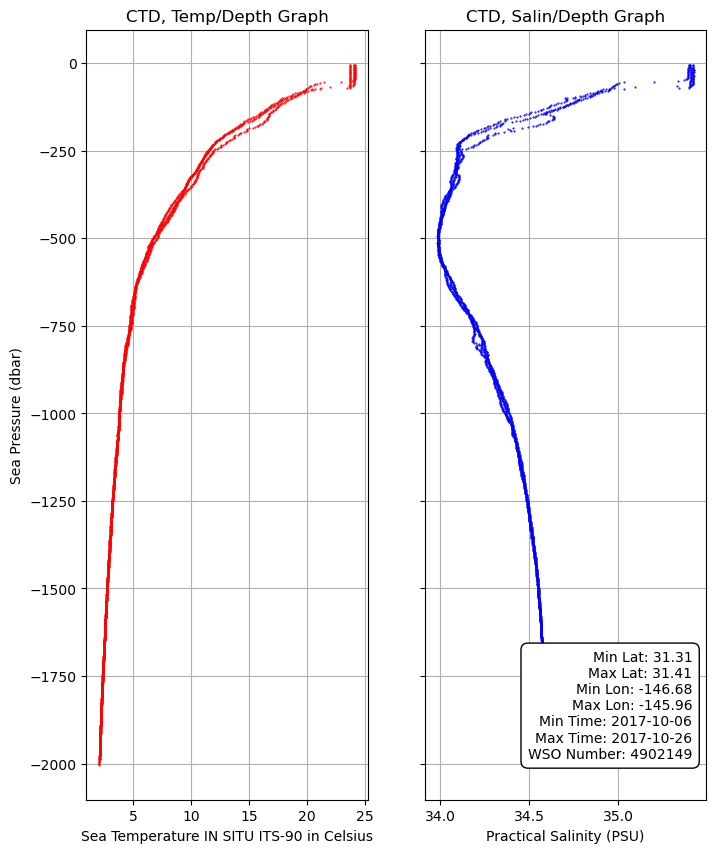

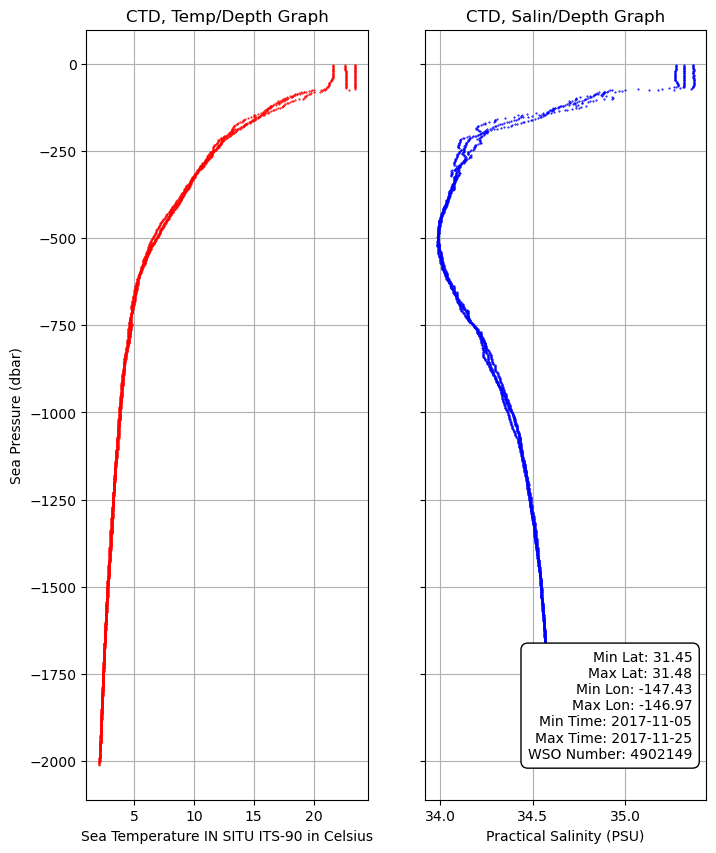

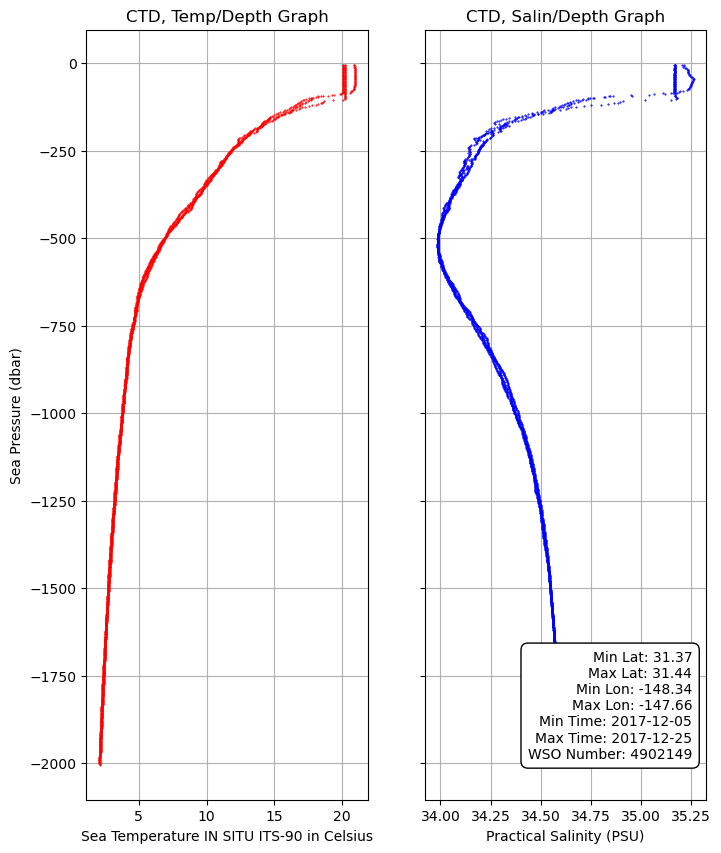

In [14]:
### Focus Region 2 for Poster - Float 4902149 - CTD Monthly data!!
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sliced_data_list = []

a_values = [4902149]
n_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for a in a_values:
    apDS = argo_loader.float(a).load().data
    data1 = apDS.argo.point2profile()
    data2 = data1.set_xindex("TIME")
    sliced_data = data2.sel(TIME=slice('2017-01-01', '2017-12-31'))
        
    #sliced_data = sliced_data.PRES.values.flatten() <= 250 # TRIED DIDN'T WORK
    
    for n in n_values:
        # Corrected the slice() function
        sliced_data_month = sliced_data.sel(TIME=sliced_data.TIME.dt.month == n)
        #sliced_data_month = sliced_data_month.where(sliced_data_month.PRES <= 250, drop=True) - DIDN'T WORK
        if (sliced_data_month.PRES <= 250).any():
            sliced_data_list.append(sliced_data_month)
            
        
        # Skip zero-size arrays
        #if sliced_data_month.isnull().any():  # Skip if any NaN values are present
            #continue


def plot_graph_and_text(ax, sliced_data, a_values):

    if (sliced_data.PRES <= 250).any():
    
        # Calculate the max and min latitude and longitude values!
        max_lat = sliced_data.LATITUDE.max().values
        min_lat = sliced_data.LATITUDE.min().values
        max_lon = sliced_data.LONGITUDE.max().values
        min_lon = sliced_data.LONGITUDE.min().values
        min_time = pd.to_datetime(sliced_data.TIME.min().values).strftime('%Y-%m-%d')
        max_time = pd.to_datetime(sliced_data.TIME.max().values).strftime('%Y-%m-%d')
        wso_identifier = sliced_data.PLATFORM_NUMBER.min().values
    
        # Calculate the number of profiles DIMENSION!
        n_prof_value = sliced_data.N_PROF.values[0]
    
        # Temperature
        ax[0].plot(sliced_data.TEMP, -sliced_data.PRES, 'ro', markersize= .5)
        ax[0].set_xlabel('Sea Temperature IN SITU ITS-90 in Celsius')
        ax[0].set_ylabel('Sea Pressure (dbar)')
        #ax[0].set_ylim(0, 250)  # Adjust the limits as needed
        ax[0].set_title('CTD, Temp/Depth Graph')
        ax[0].grid()
    
        # Salinity
        ax[1].plot(sliced_data.PSAL, -sliced_data.PRES, 'bo', markersize= .5)
        ax[1].set_title('CTD, Salin/Depth Graph')
        ax[1].set_xlabel('Practical Salinity (PSU)')
        #ax[1].set_ylim(0, 250)  # Adjust the limits as needed
        ax[1].grid()
    
        # Provide a text box with important information like lat, lon, and the number of profiles!
        text_plot = f"Min Lat: {min_lat:.2f}\nMax Lat: {max_lat:.2f}\nMin Lon: {min_lon:.2f}\nMax Lon: {max_lon:.2f}\nMin Time: {min_time}\nMax Time: {max_time}\nWSO Number: {wso_identifier}"
        ax[1].text(0.95, 0.05, text_plot, transform=ax[1].transAxes, ha='right', va='bottom', fontsize=10,
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

if (sliced_data.PRES <= 250).any():
    for a in a_values:
        apDS = argo_loader.float(a).load().data
        data1 = apDS.argo.point2profile()
        data2 = data1.set_xindex("TIME")
    
    for i, sliced_data in enumerate(sliced_data_list):
        fig, ax = plt.subplots(1, 2, figsize=(8, 10), sharey=True)
        plot_graph_and_text(ax, sliced_data, a_values)
    
    plt.show()  # Add this to display all the plots together

### Additional Steps or other Options for Mapping Monthly Data:

My attempt to plot all Argo float data month by month at once (in case you want to build off this code on your own).

ValueError: zero-size array to reduction operation fmax which has no identity

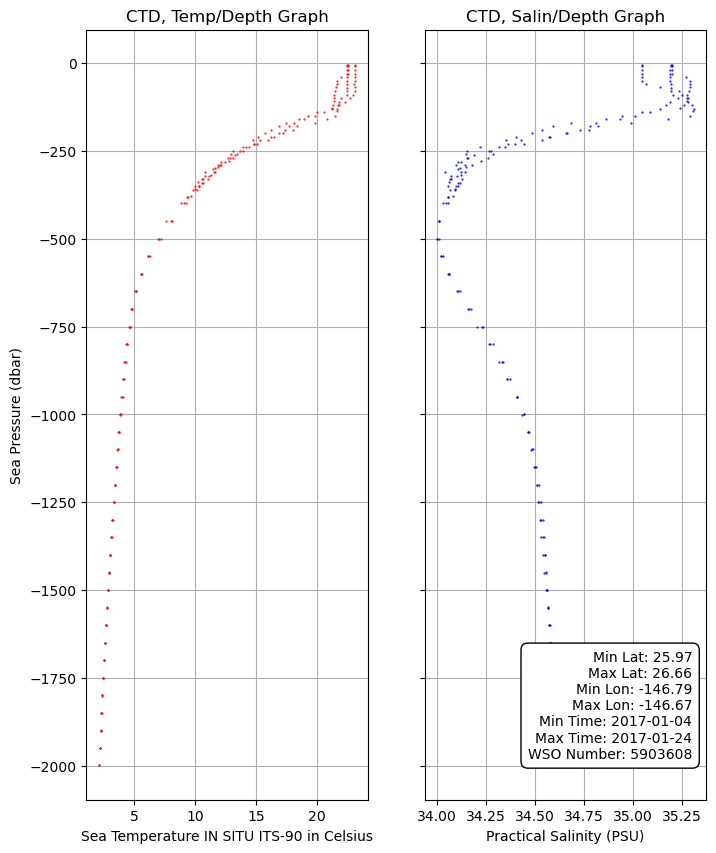

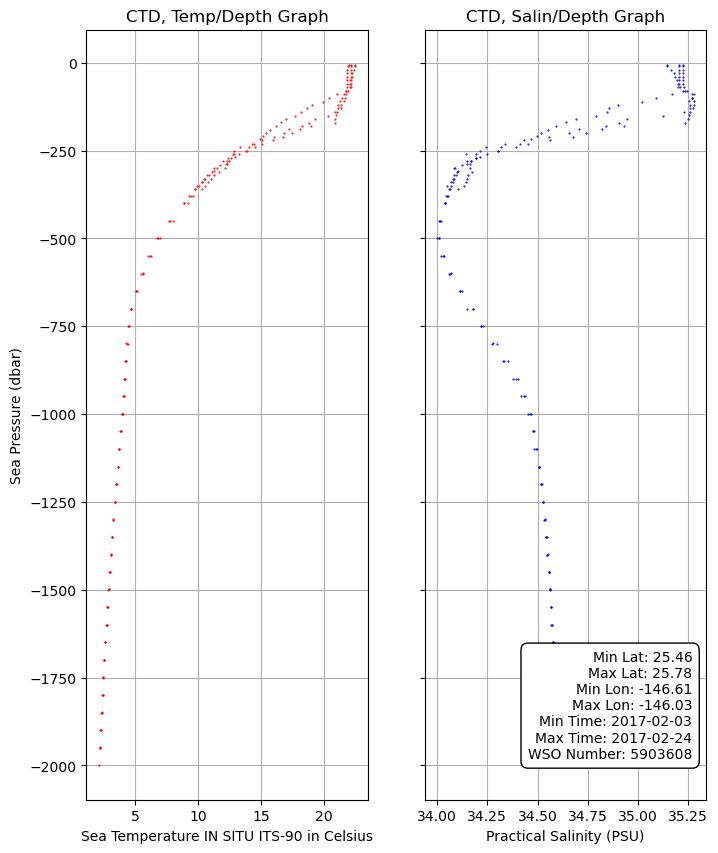

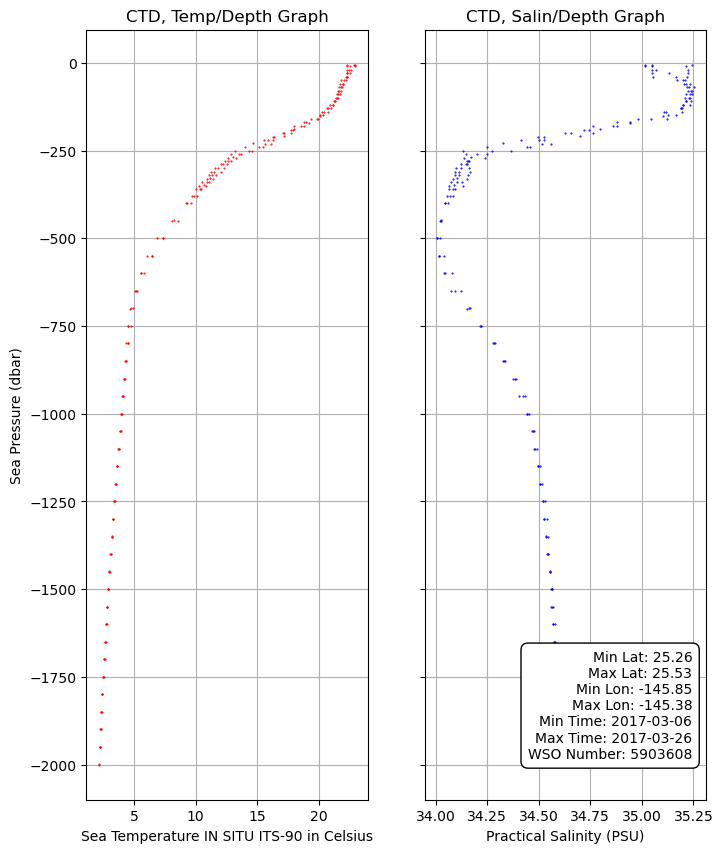

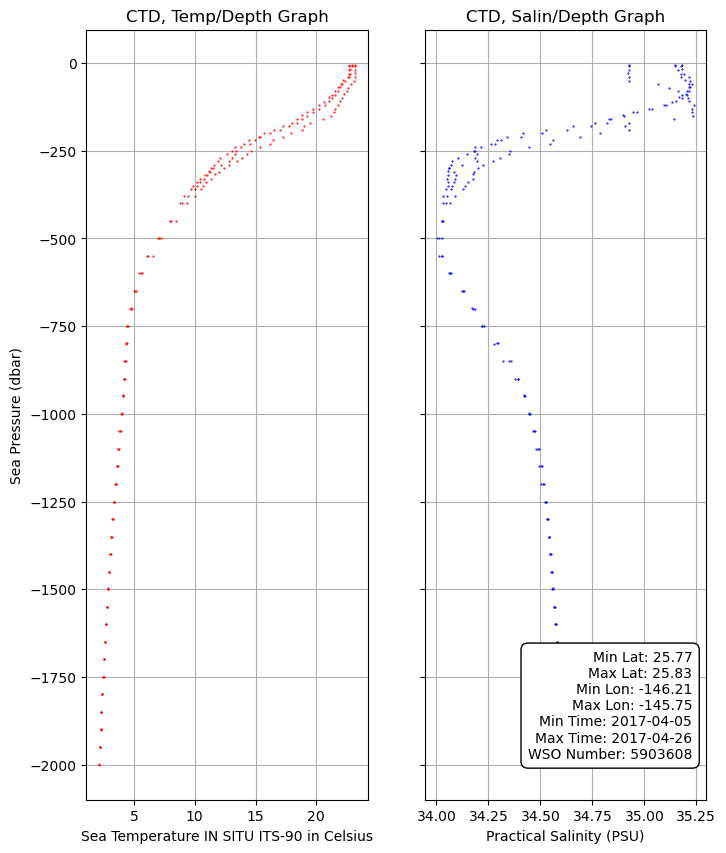

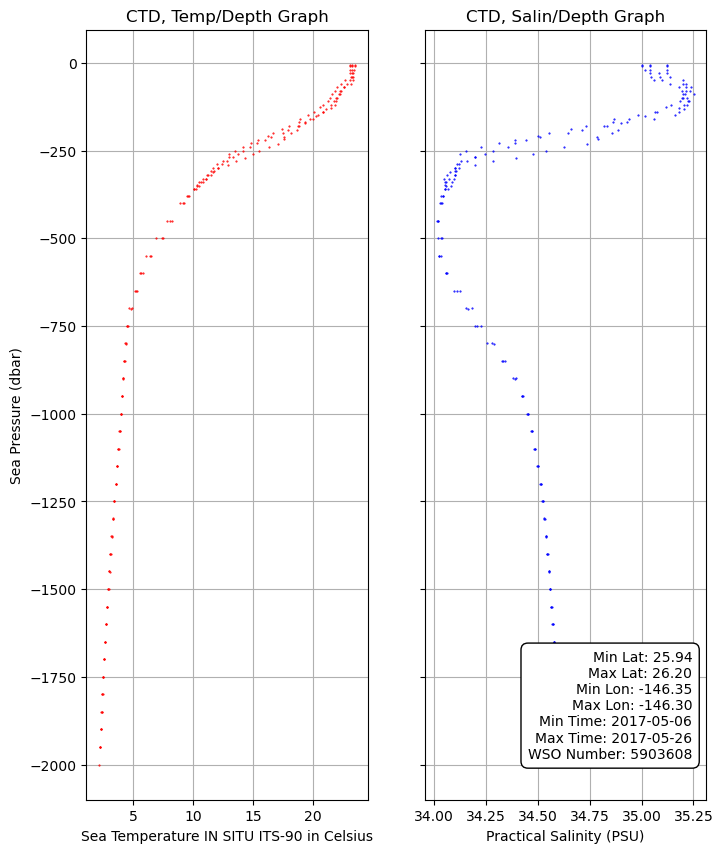

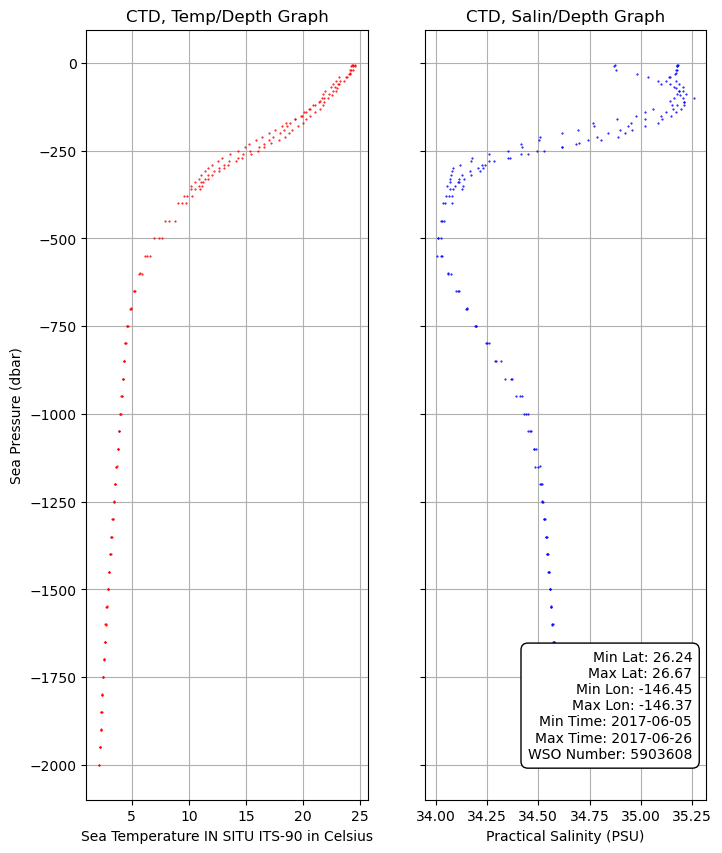

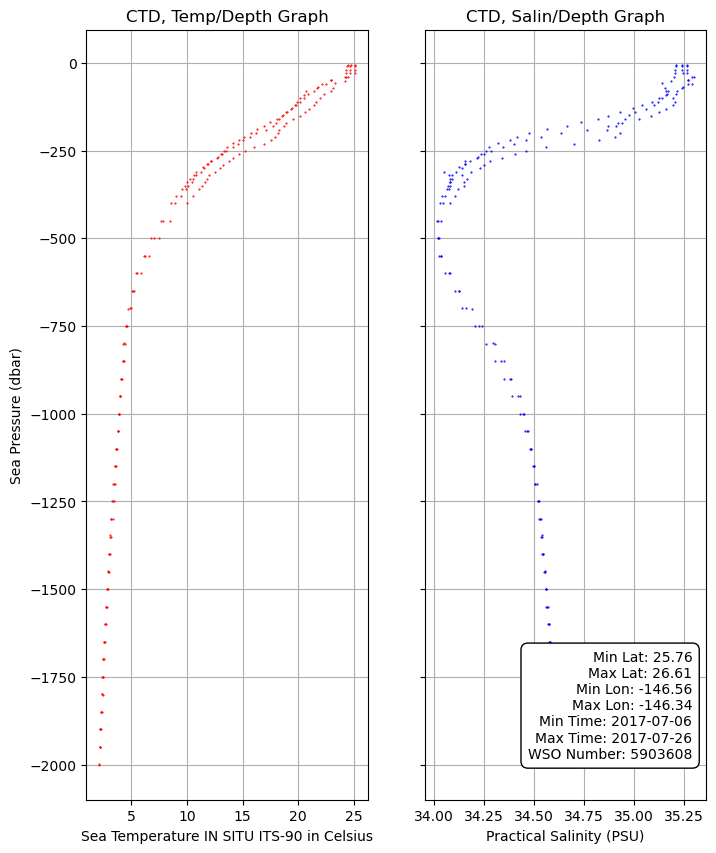

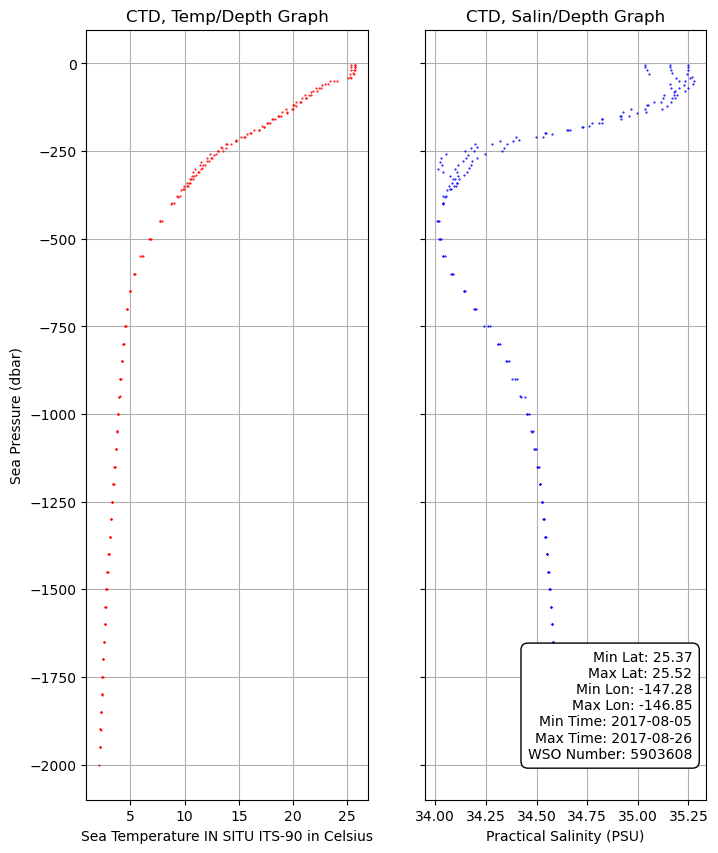

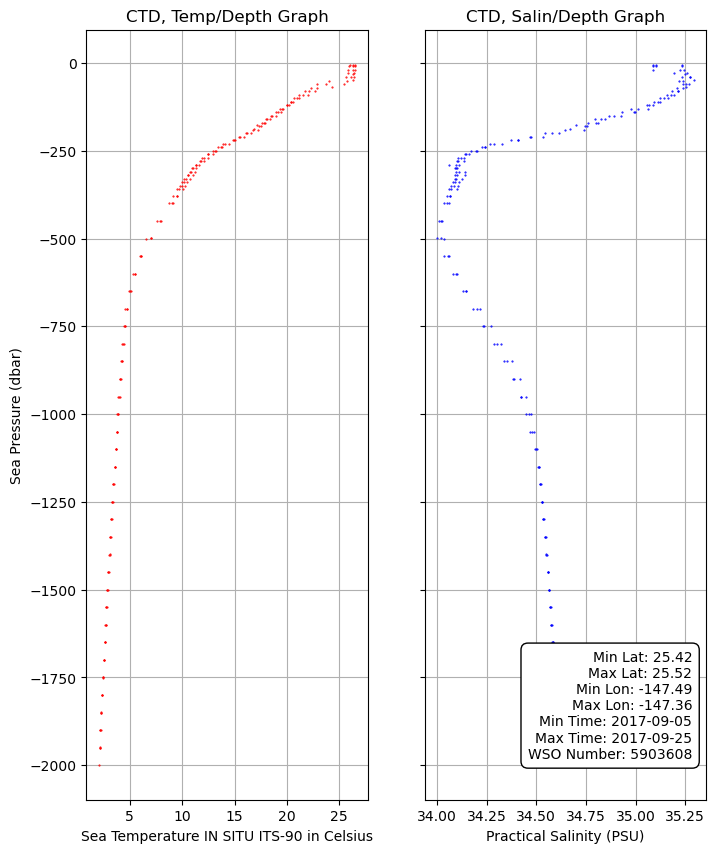

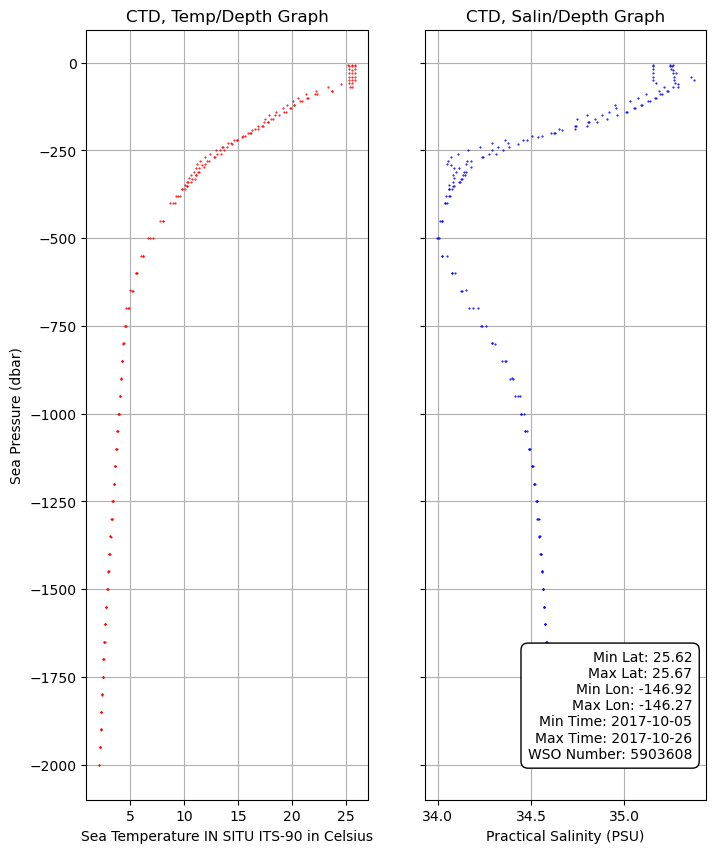

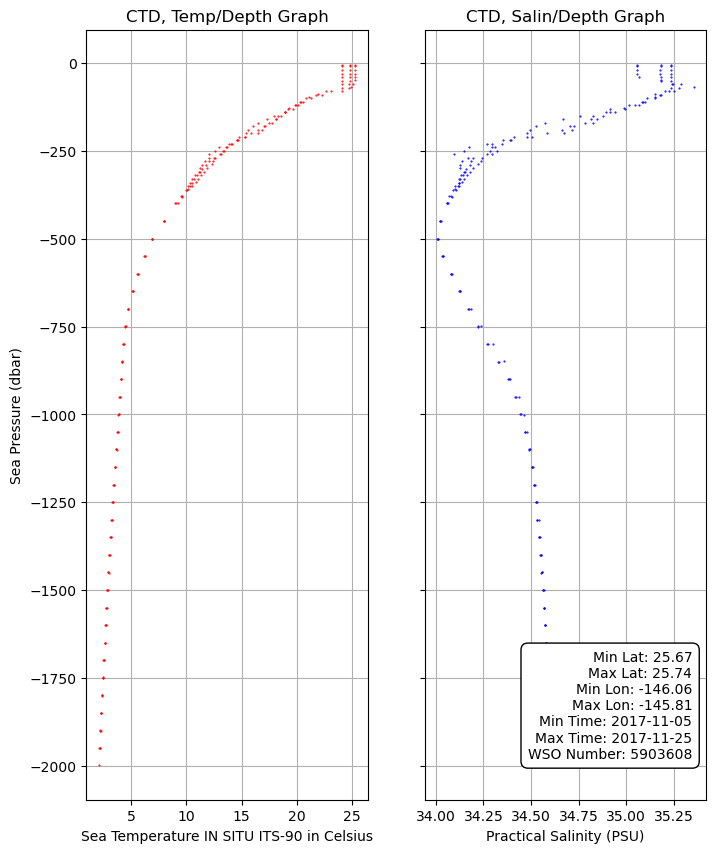

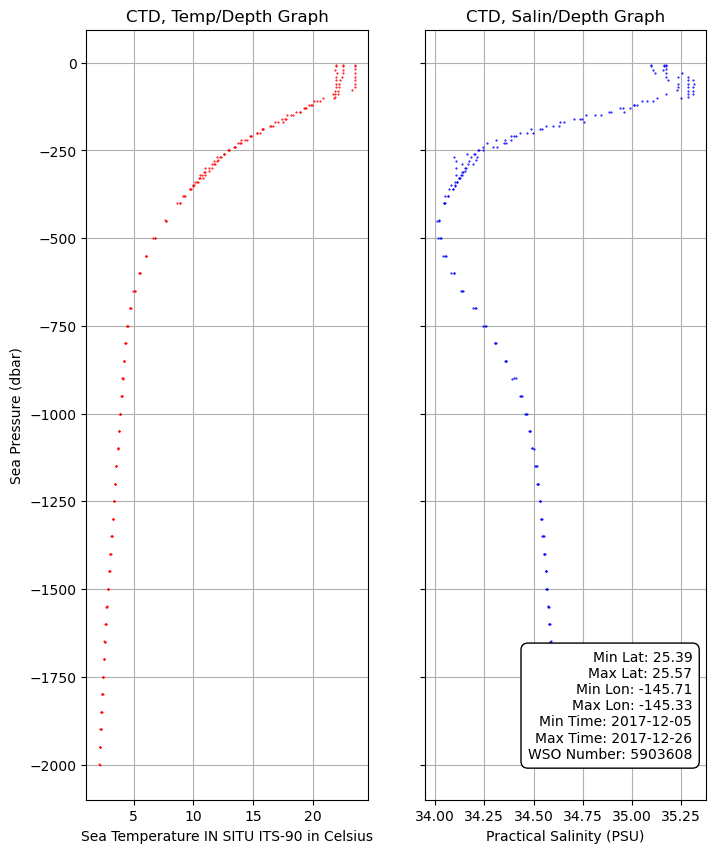

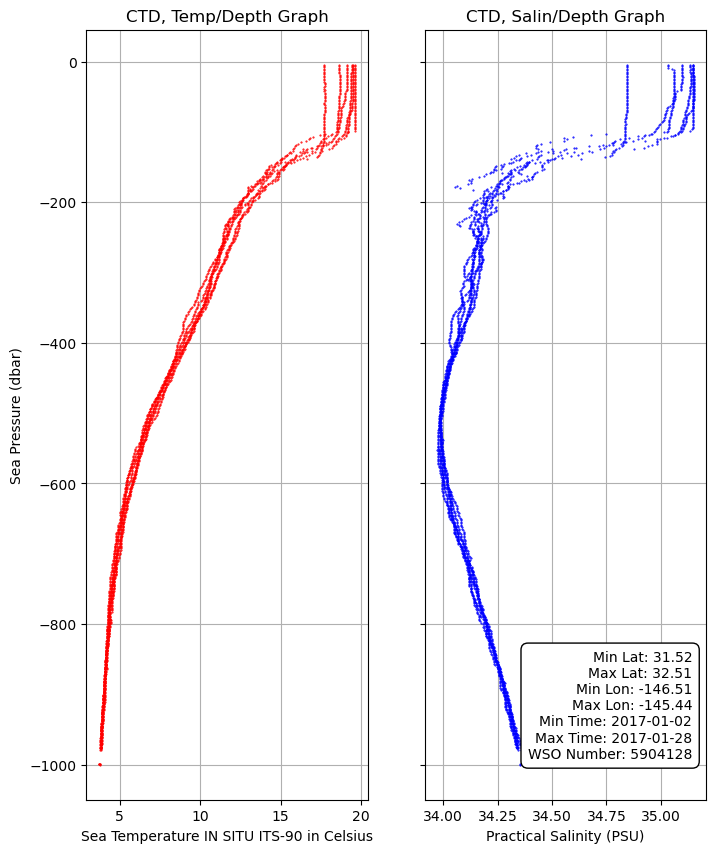

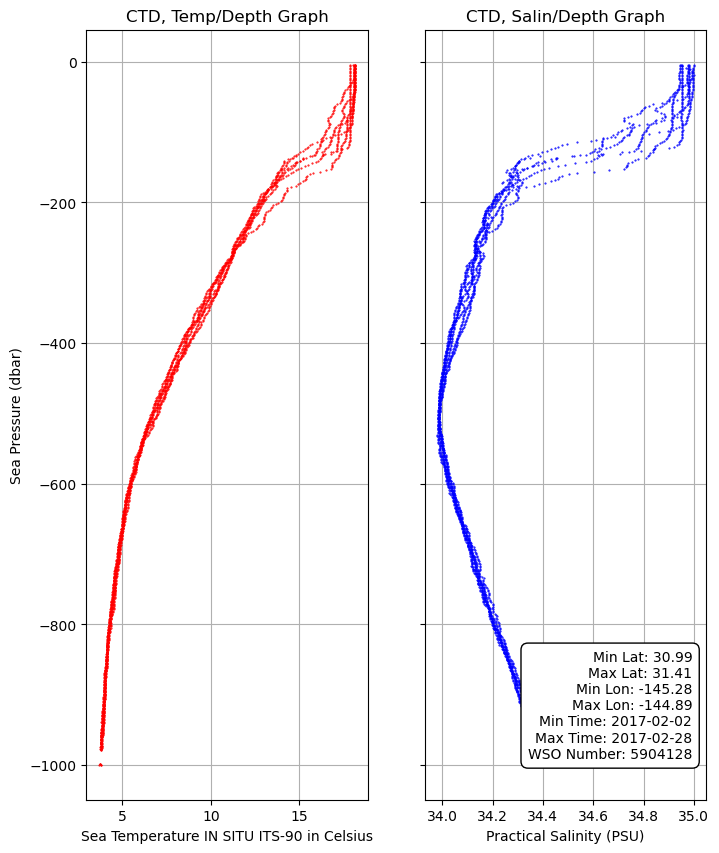

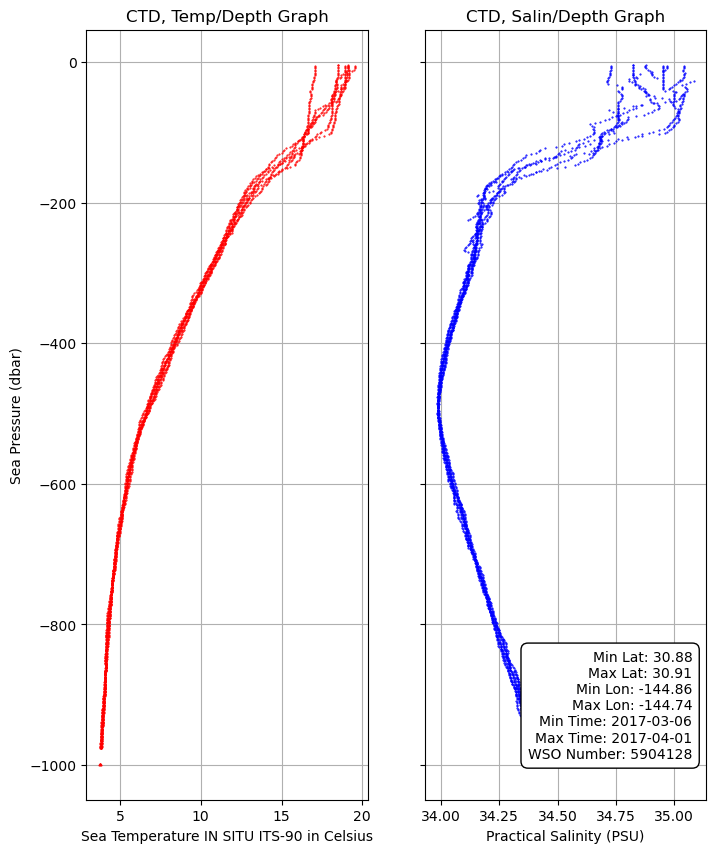

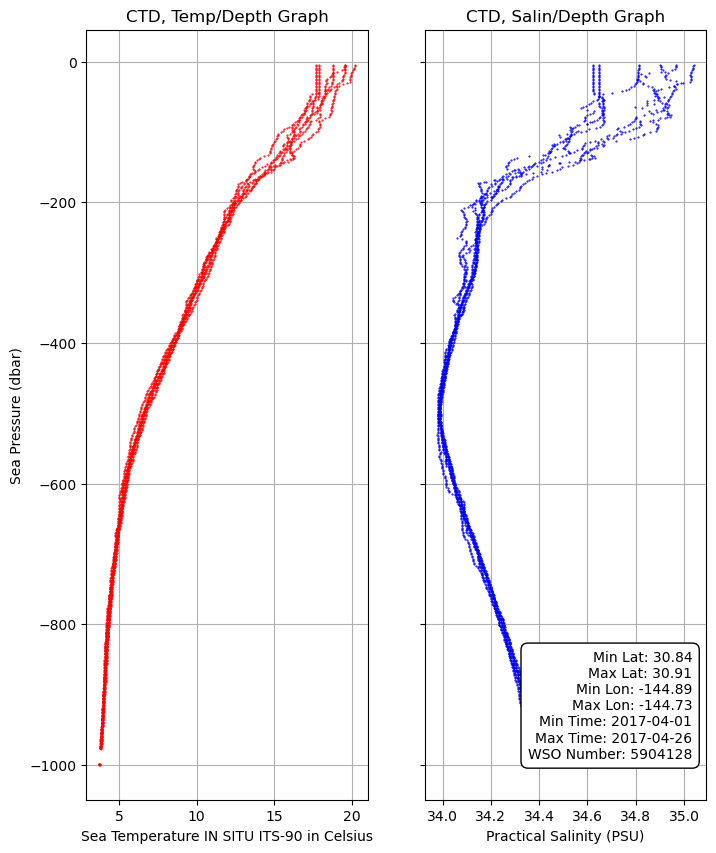

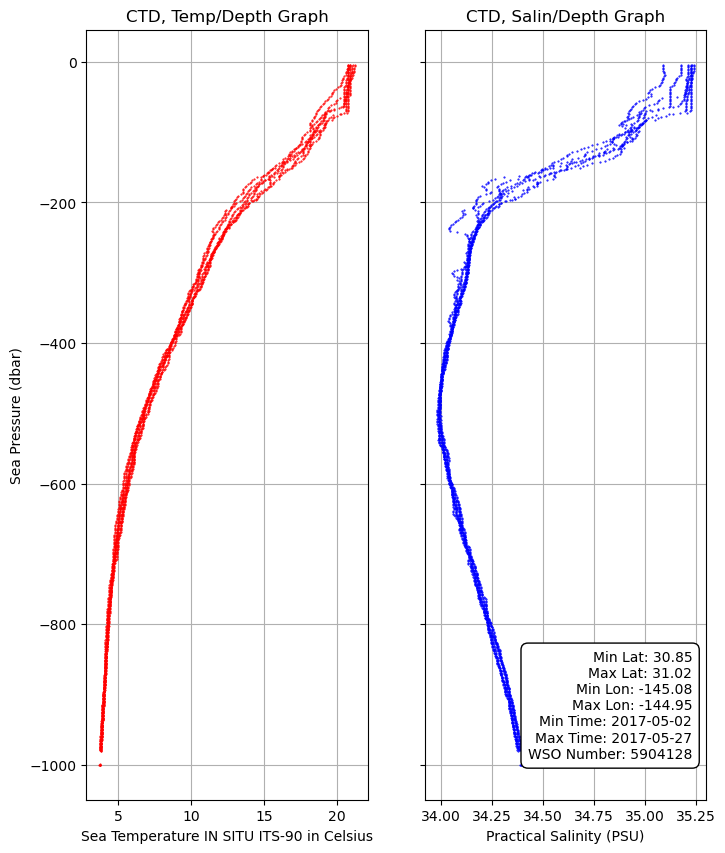

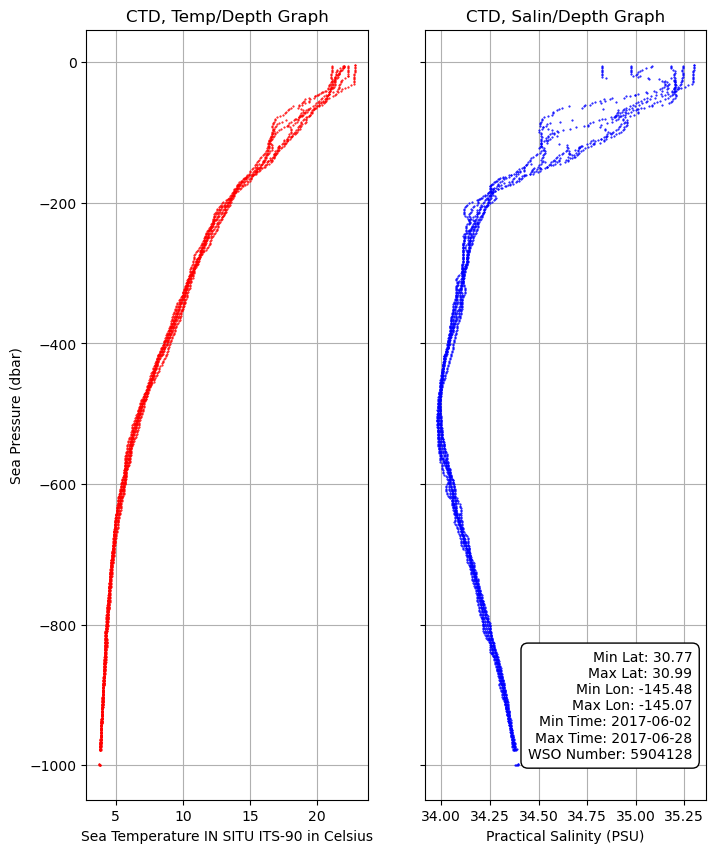

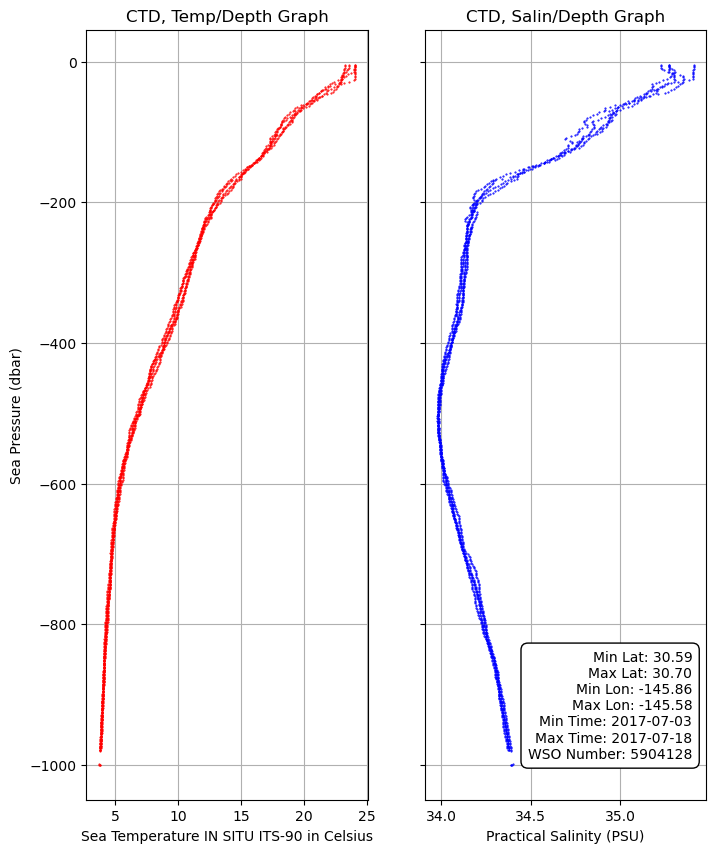

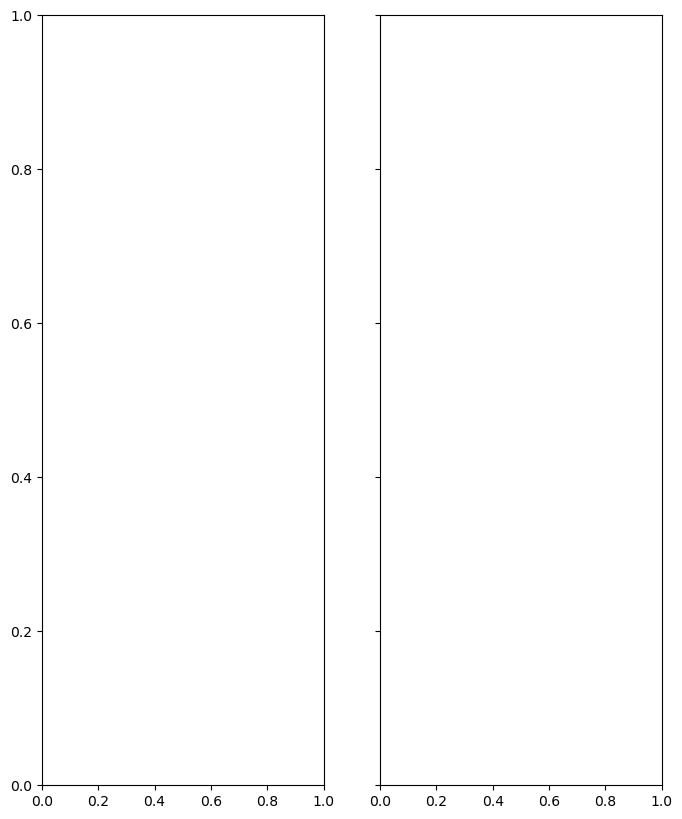

In [15]:
#The CTD graphs of each float chosen, month by month!

sliced_data_list = []

a_values = [5903608, 5904128, 5904977, 4900816, 4902251, 4902149]

for a in a_values:
    
    apDS = argo_loader.float(a).load().data
    data1 = apDS.argo.point2profile()
    data2 = data1.set_xindex("TIME")
    sliced_data = data2.sel(TIME=slice('2017-03-01','2017-12-31'))
    sliced_data_list.append(sliced_data)

import pandas as pd

def plot_graph_and_text(ax, sliced_data, a_values):
    # ... (rest of the function remains unchanged) ...
 # Calculate the max and min latitude and longitude values!
    max_lat = sliced_data.LATITUDE.max().values
    min_lat = sliced_data.LATITUDE.min().values
    max_lon = sliced_data.LONGITUDE.max().values
    min_lon = sliced_data.LONGITUDE.min().values
    min_time = pd.to_datetime(sliced_data.TIME.min().values).strftime('%Y-%m-%d')
    max_time = pd.to_datetime(sliced_data.TIME.max().values).strftime('%Y-%m-%d')
    wso_identifier = sliced_data.PLATFORM_NUMBER.min().values

    # Calculate the number of profiles DIMENSION!
    n_prof_value = sliced_data.N_PROF.values[0]

    # Temperature
    ax[0].plot(sliced_data.TEMP, -sliced_data.PRES, 'ro', markersize= .5)
    ax[0].set_xlabel('Sea Temperature IN SITU ITS-90 in Celsius')
    ax[0].set_ylabel('Sea Pressure (dbar)')
    ax[0].set_title('CTD, Temp/Depth Graph')
    ax[0].grid()

    # Salinity
    ax[1].plot(sliced_data.PSAL, -sliced_data.PRES, 'bo', markersize= .5)
    ax[1].set_title('CTD, Salin/Depth Graph')
    ax[1].set_xlabel('Practical Salinity (PSU)')
    ax[1].grid()

    # Provide a text box with important information like lat, lon, and the number of profiles!
    text_plot = f"Min Lat: {min_lat:.2f}\nMax Lat: {max_lat:.2f}\nMin Lon: {min_lon:.2f}\nMax Lon: {max_lon:.2f}\nMin Time: {min_time}\nMax Time: {max_time}\nWSO Number: {wso_identifier}"
    ax[1].text(0.95, 0.05, text_plot, transform=ax[1].transAxes, ha='right', va='bottom', fontsize=10,
               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
sliced_data_list = []
date_ranges = {
    5903608: [('2017-01-01', '2017-02-01'), ('2017-02-01', '2017-03-01'), ('2017-03-01', '2017-04-01'), ('2017-04-01', '2017-05-01'),
             ('2017-05-01', '2017-06-01'), ('2017-06-01', '2017-07-01'), ('2017-07-01', '2017-08-01'), ('2017-08-01', '2017-09-01'), ('2017-09-01', '2017-10-01'), ('2017-10-01', '2017-11-01'),
             ('2017-11-01', '2017-12-01'), ('2017-12-01', '2017-12-31')], 
    5904128: [('2017-01-01', '2017-02-01'), ('2017-02-01', '2017-03-01'), ('2017-03-01', '2017-04-01'), ('2017-04-01', '2017-05-01'),
             ('2017-05-01', '2017-06-01'), ('2017-06-01', '2017-07-01'), ('2017-07-01', '2017-08-01'), ('2017-08-01', '2017-09-01'), ('2017-09-01', '2017-10-01'), ('2017-10-01', '2017-11-01'),
             ('2017-11-01', '2017-12-01'), ('2017-12-01', '2017-12-31')],
    5904977: [('2017-01-01', '2017-02-01'), ('2017-02-01', '2017-03-01'), ('2017-03-01', '2017-04-01'), ('2017-04-01', '2017-05-01'),
             ('2017-05-01', '2017-06-01'), ('2017-06-01', '2017-07-01'), ('2017-07-01', '2017-08-01'), ('2017-08-01', '2017-09-01'), ('2017-09-01', '2017-10-01'), ('2017-10-01', '2017-11-01'),
             ('2017-11-01', '2017-12-01'), ('2017-12-01', '2017-12-31')],
    4900816: [('2017-01-01', '2017-02-01'), ('2017-02-01', '2017-03-01'), ('2017-03-01', '2017-04-01'), ('2017-04-01', '2017-05-01'),
             ('2017-05-01', '2017-06-01'), ('2017-06-01', '2017-07-01'), ('2017-07-01', '2017-08-01'), ('2017-08-01', '2017-09-01'), ('2017-09-01', '2017-10-01'), ('2017-10-01', '2017-11-01'),
             ('2017-11-01', '2017-12-01'), ('2017-12-01', '2017-12-31')],
    4902251: [('2017-01-01', '2017-02-01'), ('2017-02-01', '2017-03-01'), ('2017-03-01', '2017-04-01'), ('2017-04-01', '2017-05-01'),
             ('2017-05-01', '2017-06-01'), ('2017-06-01', '2017-07-01'), ('2017-07-01', '2017-08-01'), ('2017-08-01', '2017-09-01'), ('2017-09-01', '2017-10-01'), ('2017-10-01', '2017-11-01'),
             ('2017-11-01', '2017-12-01'), ('2017-12-01', '2017-12-31')],
    4902149: [('2017-01-01', '2017-02-01'), ('2017-02-01', '2017-03-01'), ('2017-03-01', '2017-04-01'), ('2017-04-01', '2017-05-01'),
             ('2017-05-01', '2017-06-01'), ('2017-06-01', '2017-07-01'), ('2017-07-01', '2017-08-01'), ('2017-08-01', '2017-09-01'), ('2017-09-01', '2017-10-01'), ('2017-10-01', '2017-11-01'),
             ('2017-11-01', '2017-12-01'), ('2017-12-01', '2017-12-31')] #Not included because not in my own chosen bounding box regions.
}

        
for a in a_values:
    apDS = argo_loader.float(a).load().data
    data1 = apDS.argo.point2profile()
    data2 = data1.set_xindex("TIME")

    for date_range in date_ranges[a]:
        sliced_data = data2.sel(TIME=slice(date_range[0], date_range[1]))
        sliced_data_list.append(sliced_data)

for i, sliced_data in enumerate(sliced_data_list):
    fig, ax = plt.subplots(1, 2, figsize=(8, 10), sharey=True)
    plot_graph_and_text(ax, sliced_data, a_values)

plt.show()  # Add this to display all the plots together

Initially, I had done this search by hand using the ArgoIndexFetcher and then ran into some issues with the code not skipping monthly intervals that had no data, and so I checked whether every month had a value and which month intervals did not for each region.

For Region #1:

In [16]:
#My hand-chosen bounds based on the max and min of starting points within the SMILE experiment, no time restriction
idx1 = ArgoIndexFetcher(src='erddap').region([-146.322, -145, 25.5, 28.0, '2017-01-01', '2017-12-31']).load()
idx1.index

file                date  longitude  \
0   aoml/5903608/profiles/D5903608_191.nc 2017-02-14 00:36:48   -146.275   
1   aoml/5903608/profiles/D5903608_195.nc 2017-03-26 16:07:05   -145.377   
2   aoml/5903608/profiles/D5903608_196.nc 2017-04-05 20:18:11   -145.748   
3   aoml/5903608/profiles/D5903608_197.nc 2017-04-16 00:51:16   -145.965   
4   aoml/5903608/profiles/D5903608_198.nc 2017-04-26 04:13:57   -146.208   
5   aoml/5903608/profiles/D5903608_201.nc 2017-05-26 16:46:29   -146.298   
6   aoml/5903608/profiles/D5903608_216.nc 2017-10-26 04:36:06   -146.269   
7   aoml/5903608/profiles/D5903608_217.nc 2017-11-05 08:50:52   -146.065   
8   aoml/5904977/profiles/D5904977_027.nc 2017-11-13 07:53:40   -146.277   
9   aoml/5903608/profiles/D5903608_218.nc 2017-11-15 12:06:13   -145.919   
10  aoml/5904977/profiles/D5904977_028.nc 2017-11-23 08:52:22   -145.776   
11  aoml/5903608/profiles/D5903608_219.nc 2017-11-25 16:49:34   -145.815   
12  aoml/5904977/profiles/D5904977_029.nc 2017-12-03 07:56:46   -145.461   
13  aoml/5903608/profiles/D5903608_220.nc 2017-12-05 20:02:44   -145.710   
14  aoml/5904977/profiles/D5904977_030.nc 2017-12-13 08:49:52   -145.193   
15  aoml/5904977/profiles/D5904977_031.nc 2017-12-23 08:01:51   -145.131   

    latitude ocean  profiler_code institution_code         date_update  \
0     25.613     P            846               AO 2017-12-11 11:11:41   
1     25.532     P            846               AO 2017-12-11 11:11:42   
2     25.765     P            846               AO 2017-12-11 11:11:42   
3     25.801     P            846               AO 2017-12-11 11:11:43   
4     25.828     P            846               AO 2017-12-11 11:11:43   
5     26.201     P            846               AO 2017-12-11 11:11:43   
6     25.674     P            846               AO 2017-12-11 11:11:44   
7     25.743     P            846               AO 2017-12-11 11:11:44   
8     27.273     P            863               AO 2018-11-03 10:20:42   
9     25.736     P            846               AO 2017-12-11 11:11:44   
10    27.231     P            863               AO 2018-11-03 10:20:42   
11    25.671     P            846               AO 2017-12-11 11:11:44   
12    27.335     P            863               AO 2018-11-03 10:20:43   
13    25.568     P            846               AO 2020-01-27 10:24:52   
14    27.381     P            863               AO 2018-11-03 10:20:43   
15    27.415     P            863               AO 2018-11-03 10:20:43   

        wmo institution                       profiler  
0   5903608   AOML, USA  Webb Research, Seabird sensor  
1   5903608   AOML, USA  Webb Research, Seabird sensor  
2   5903608   AOML, USA  Webb Research, Seabird sensor  
3   5903608   AOML, USA  Webb Research, Seabird sensor  
4   5903608   AOML, USA  Webb Research, Seabird sensor  
5   5903608   AOML, USA  Webb Research, Seabird sensor  
6   5903608   AOML, USA  Webb Research, Seabird sensor  
7   5903608   AOML, USA  Webb Research, Seabird sensor  
8   5904977   AOML, USA                  Navis-A Float  
9   5903608   AOML, USA  Webb Research, Seabird sensor  
10  5904977   AOML, USA                  Navis-A Float  
11  5903608   AOML, USA  Webb Research, Seabird sensor  
12  5904977   AOML, USA                  Navis-A Float  
13  5903608   AOML, USA  Webb Research, Seabird sensor  
14  5904977   AOML, USA                  Navis-A Float  
15  5904977   AOML, USA                  Navis-A Float

In [17]:
SMILE_floats_D1 = idx1.index.wmo
SMILE_floats_ND1 = SMILE_floats_D1.drop_duplicates()
SMILE_floats_ND1

0    5903608
8    5904977
Name: wmo, dtype: int64

For Region #2:

In [18]:
idx2 = ArgoIndexFetcher(src='erddap').region([-146.322, -145, 28.0, 30.6, '2017-01-01', '2017-12-31']).load()
idx2.index

file                date  longitude  \
0  aoml/5904128/profiles/D5904128_283.nc 2017-07-18 18:12:37   -145.856   

   latitude ocean  profiler_code institution_code         date_update  \
0    30.592     P            846               AO 2019-06-04 15:33:17   

       wmo institution                       profiler  
0  5904128   AOML, USA  Webb Research, Seabird sensor

In [19]:
SMILE_floats_D2 = idx2.index.wmo
SMILE_floats_ND2 = SMILE_floats_D2.drop_duplicates()
SMILE_floats_ND2

0    5904128
Name: wmo, dtype: int64

In [20]:
idx3 = ArgoIndexFetcher(src='erddap').region([-140.5,-139.39713, 34.0, 35.469333, '2017-01-01', '2017-12-31']).load()
idx3.index

file                date  longitude  \
0   aoml/4900816/profiles/R4900816_346.nc 2017-06-21 21:46:12   -139.591   
1   aoml/4900816/profiles/R4900816_347.nc 2017-07-02 15:01:15   -139.592   
2    jma/4902251/profiles/D4902251_159.nc 2017-07-26 09:23:53   -140.212   
3    jma/4902251/profiles/D4902251_160.nc 2017-08-05 09:21:43   -140.198   
4    jma/4902251/profiles/D4902251_161.nc 2017-08-15 09:14:11   -140.153   
5    jma/4902251/profiles/D4902251_162.nc 2017-08-25 09:23:10   -140.106   
6    jma/4902251/profiles/D4902251_163.nc 2017-09-04 09:20:06   -140.072   
7    jma/4902251/profiles/D4902251_164.nc 2017-09-14 09:21:16   -140.020   
8    jma/4902251/profiles/D4902251_166.nc 2017-10-04 09:27:14   -140.083   
9    jma/4902251/profiles/D4902251_167.nc 2017-10-14 09:26:58   -140.183   
10   jma/4902251/profiles/D4902251_168.nc 2017-10-24 09:25:05   -140.278   
11   jma/4902251/profiles/D4902251_169.nc 2017-11-03 09:24:41   -140.375   
12   jma/4902251/profiles/D4902251_170.nc 2017-11-13 09:19:35   -140.420   
13   jma/4902251/profiles/D4902251_171.nc 2017-11-23 09:13:37   -140.476   
14   jma/4902251/profiles/D4902251_172.nc 2017-12-03 09:15:35   -140.485   
15   jma/4902251/profiles/D4902251_174.nc 2017-12-23 09:16:48   -140.498   

    latitude ocean  profiler_code institution_code         date_update  \
0     34.262     P            846               AO 2017-06-22 18:31:24   
1     34.542     P            846               AO 2017-07-03 01:33:05   
2     35.415     P            863               JA 2020-01-15 03:15:19   
3     35.291     P            863               JA 2020-01-15 03:15:19   
4     35.154     P            863               JA 2020-01-15 03:15:19   
5     35.059     P            863               JA 2020-01-15 03:15:20   
6     34.937     P            863               JA 2020-01-15 03:15:20   
7     34.804     P            863               JA 2020-01-15 03:15:19   
8     34.428     P            863               JA 2020-01-15 03:15:18   
9     34.458     P            863               JA 2020-01-15 03:15:18   
10    34.445     P            863               JA 2020-01-15 03:15:18   
11    34.473     P            863               JA 2020-01-15 03:15:17   
12    34.477     P            863               JA 2020-01-15 03:15:18   
13    34.485     P            863               JA 2020-01-15 03:15:19   
14    34.465     P            863               JA 2020-01-15 03:15:19   
15    34.509     P            863               JA 2020-01-15 03:15:20   

        wmo institution                       profiler  
0   4900816   AOML, USA  Webb Research, Seabird sensor  
1   4900816   AOML, USA  Webb Research, Seabird sensor  
2   4902251  JMA, Japan                  Navis-A Float  
3   4902251  JMA, Japan                  Navis-A Float  
4   4902251  JMA, Japan                  Navis-A Float  
5   4902251  JMA, Japan                  Navis-A Float  
6   4902251  JMA, Japan                  Navis-A Float  
7   4902251  JMA, Japan                  Navis-A Float  
8   4902251  JMA, Japan                  Navis-A Float  
9   4902251  JMA, Japan                  Navis-A Float  
10  4902251  JMA, Japan                  Navis-A Float  
11  4902251  JMA, Japan                  Navis-A Float  
12  4902251  JMA, Japan                  Navis-A Float  
13  4902251  JMA, Japan                  Navis-A Float  
14  4902251  JMA, Japan                  Navis-A Float  
15  4902251  JMA, Japan                  Navis-A Float

In [21]:
SMILE_floats_D3 = idx3.index.wmo
SMILE_floats_ND3 = SMILE_floats_D3.drop_duplicates()
SMILE_floats_ND3

0    4900816
2    4902251
Name: wmo, dtype: int64

Then I individually plotted the idx again but for every month seperately instead of for the entire year of 2017. When I got a month interval that did not exist, I got an error code and thus there was no data available. After doing this for each month, I manually removed the monthly intervals that were giving me issues from the last bit of code that would graph CTD graphs of all profiles within 2017 by month for each float that intersects regions 1,2, and 3.

Example of a month interval that worked:

In [22]:
idx2 = ArgoIndexFetcher(src='erddap').region([-146.322, -145, 28.0, 30.6, '2017-07-01', '2017-08-01']).load()
idx2.index

file                date  longitude  \
0  aoml/5904128/profiles/D5904128_283.nc 2017-07-18 18:12:37   -145.856   

   latitude ocean  profiler_code institution_code         date_update  \
0    30.592     P            846               AO 2019-06-04 15:33:17   

       wmo institution                       profiler  
0  5904128   AOML, USA  Webb Research, Seabird sensor

Example of a month interval that DIDN't work:

In [23]:
idx2 = ArgoIndexFetcher(src='erddap').region([-146.322, -145, 28.0, 30.6, '2017-08-01', '2017-09-01']).load()
idx2.index

FileNotFoundError: https://erddap.ifremer.fr/erddap/tabledap/ArgoFloats-index.csv?file,date,longitude,latitude,ocean,profiler_type,institution,date_update&longitude>=-146.322&longitude<=-145&latitude>=28.0&latitude<=30.6&date>="2017-08-01"&date<="2017-09-01"&distinct()&orderBy("date")

Manual Removal of Months that Didn't Work:

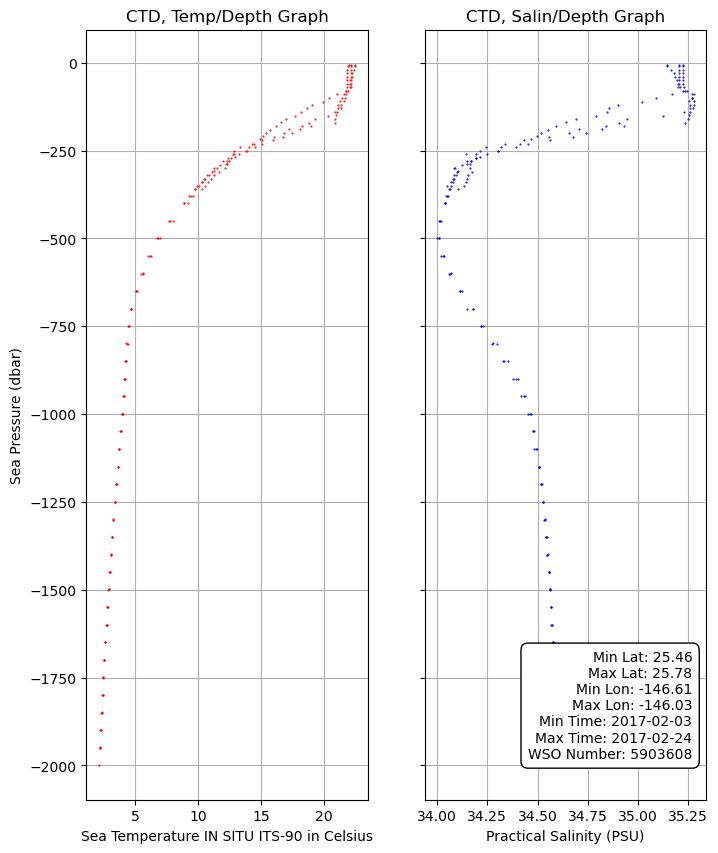

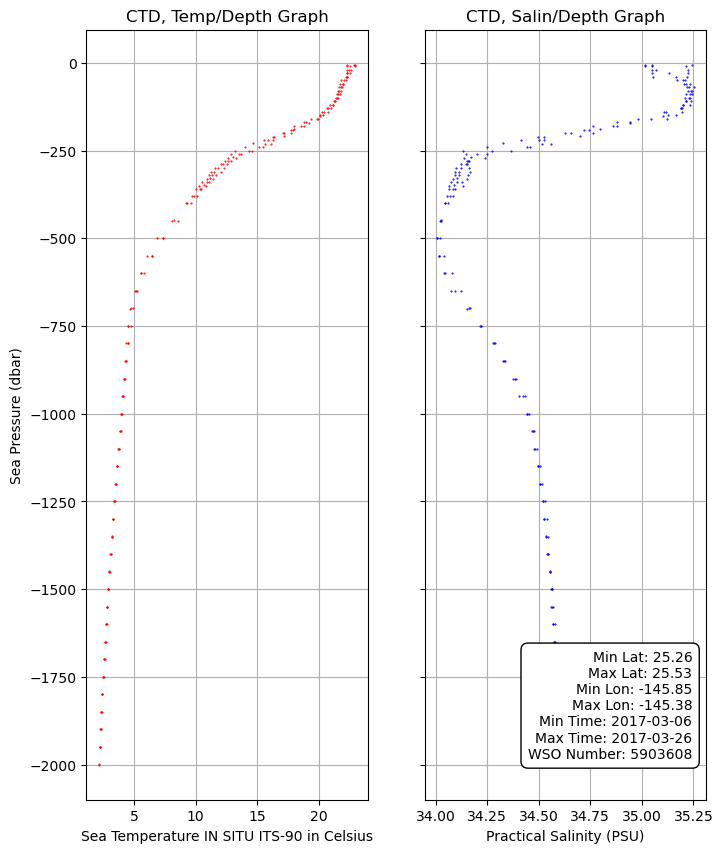

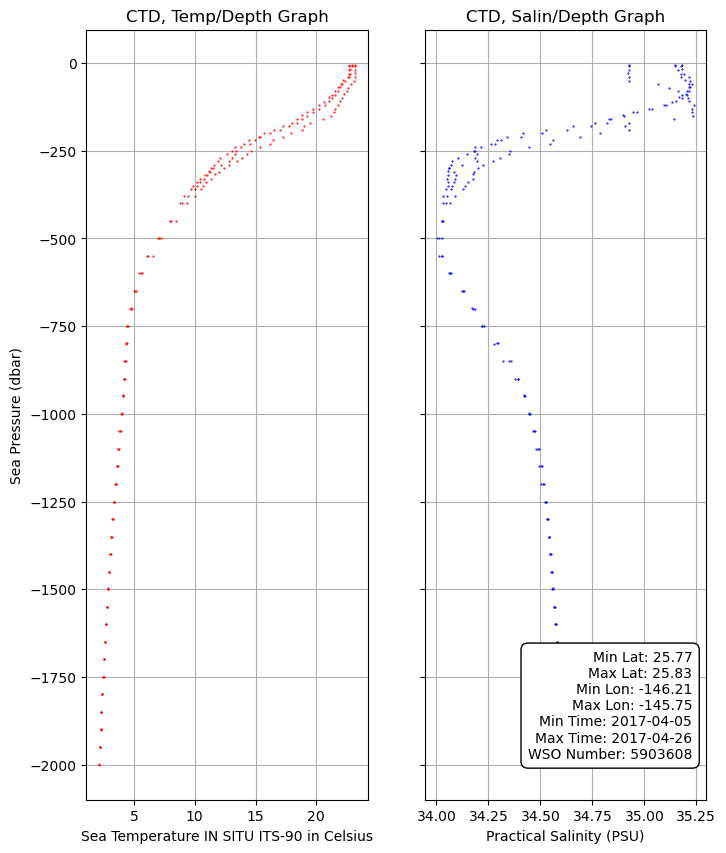

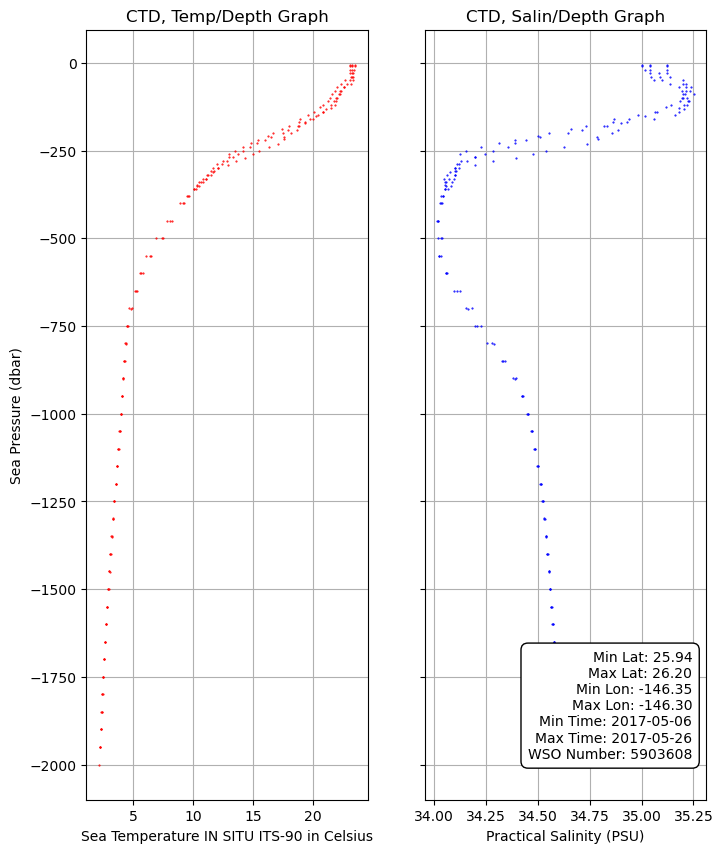

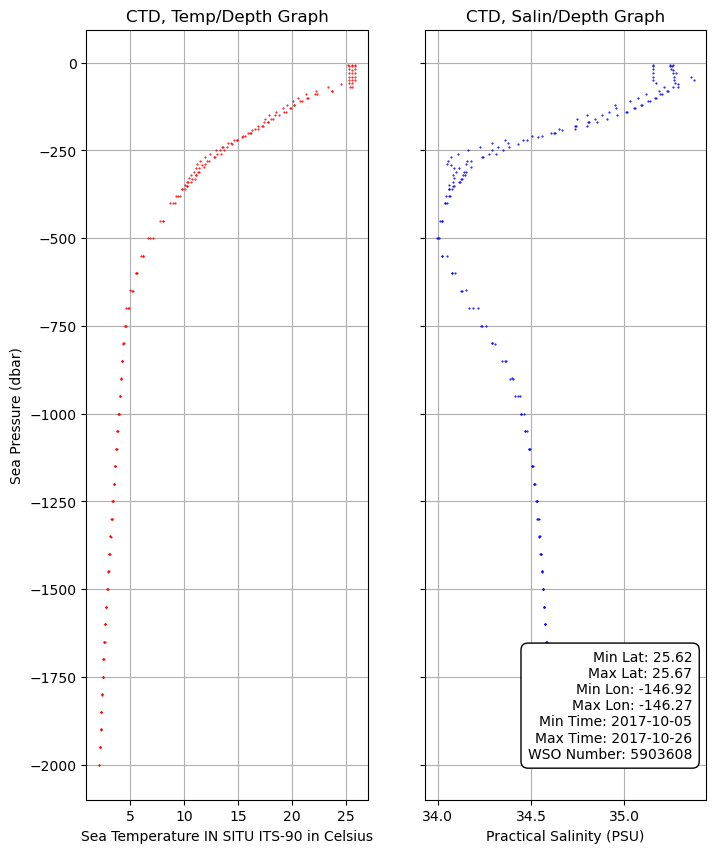

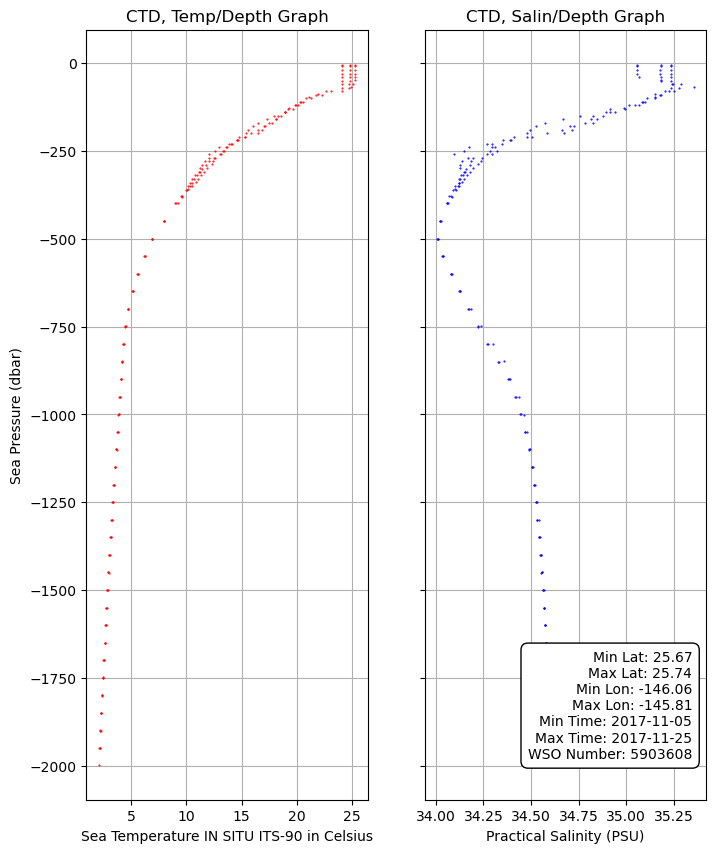

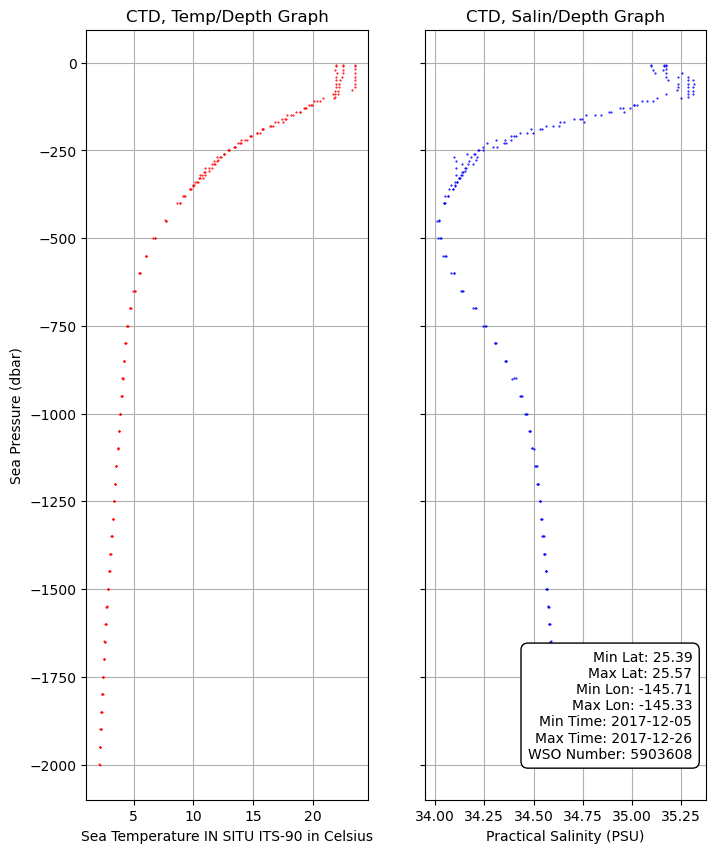

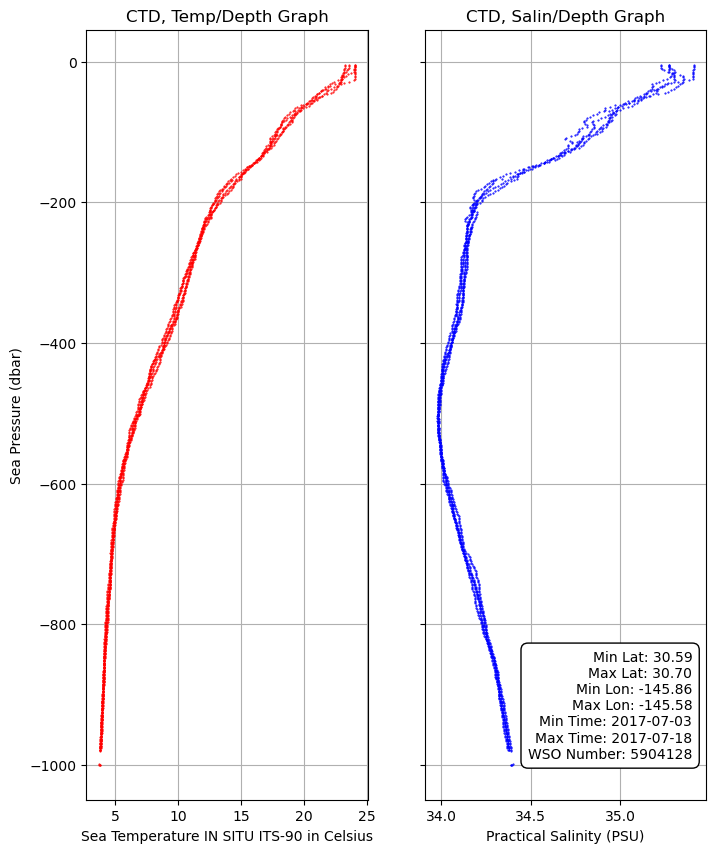

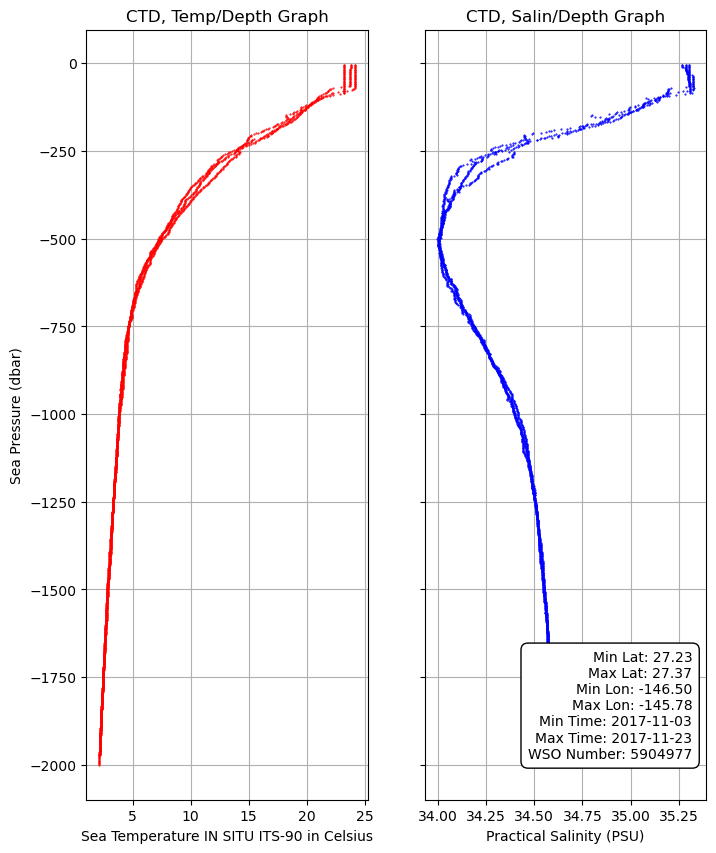

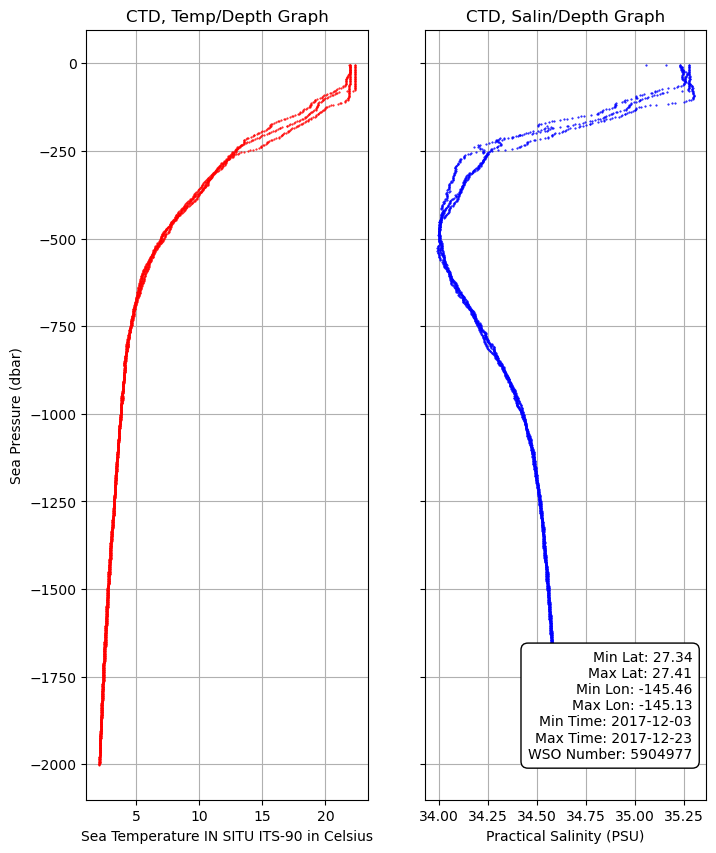

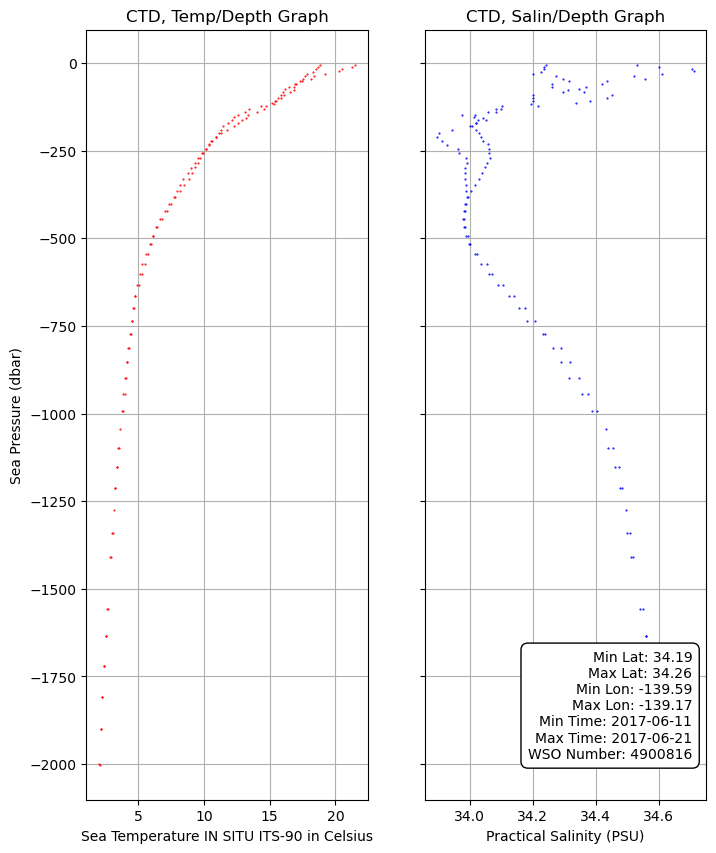

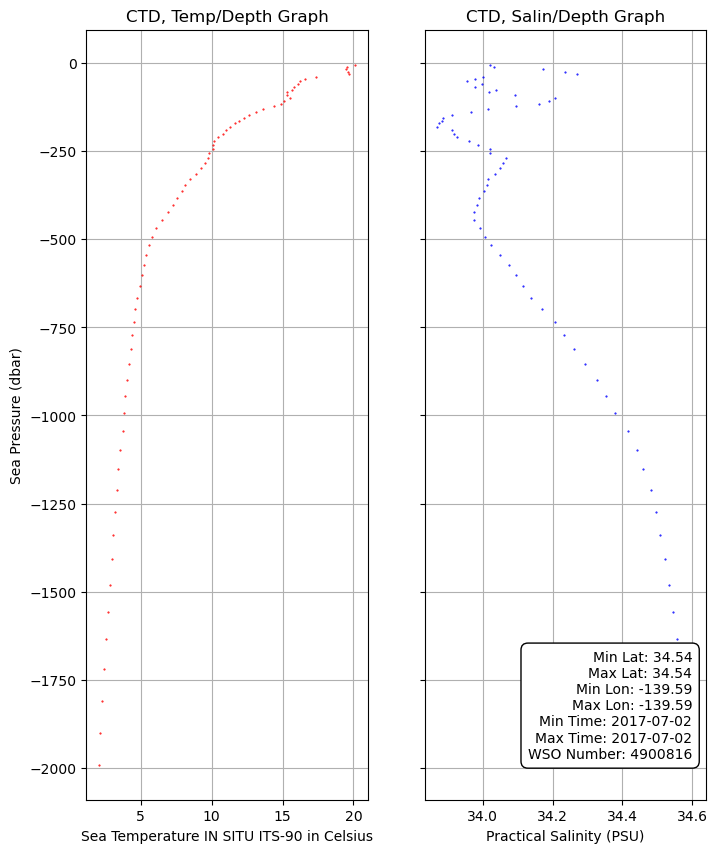

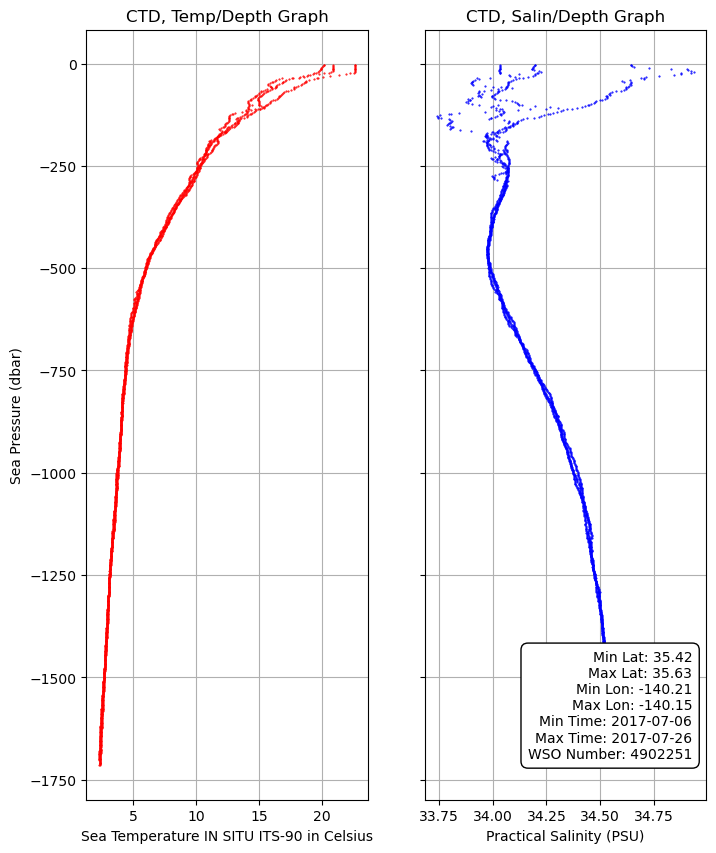

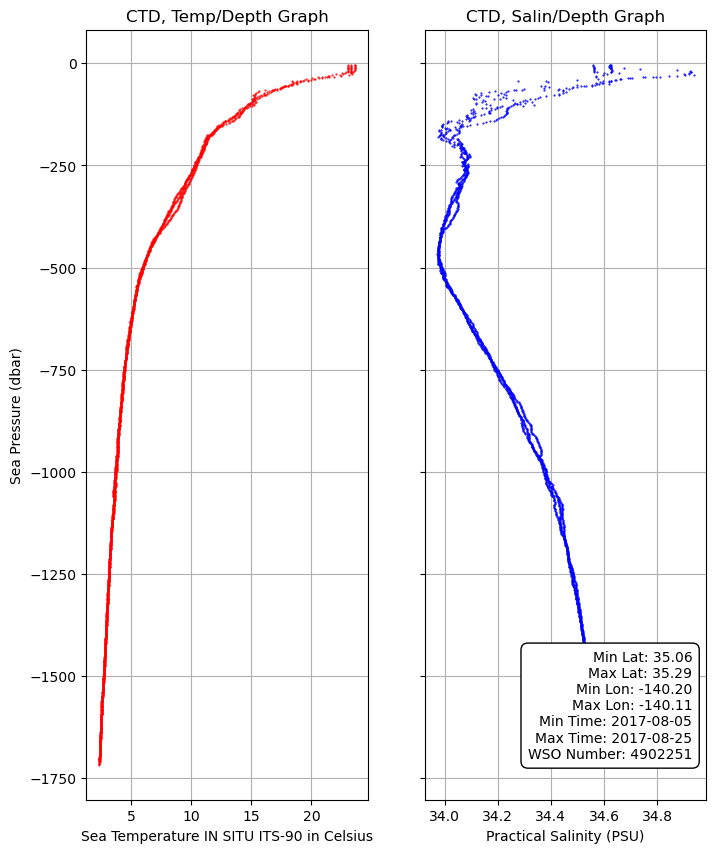

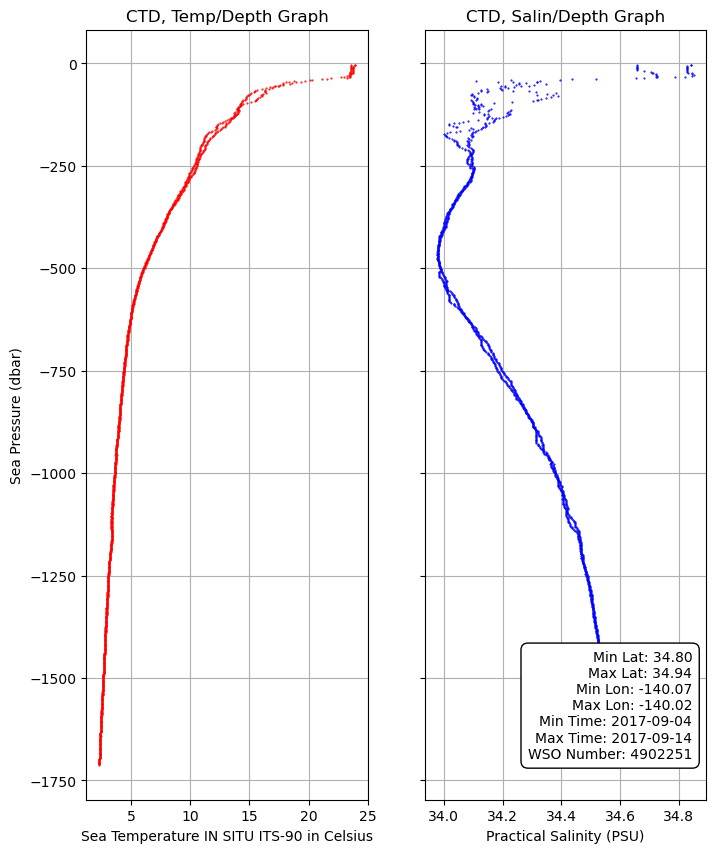

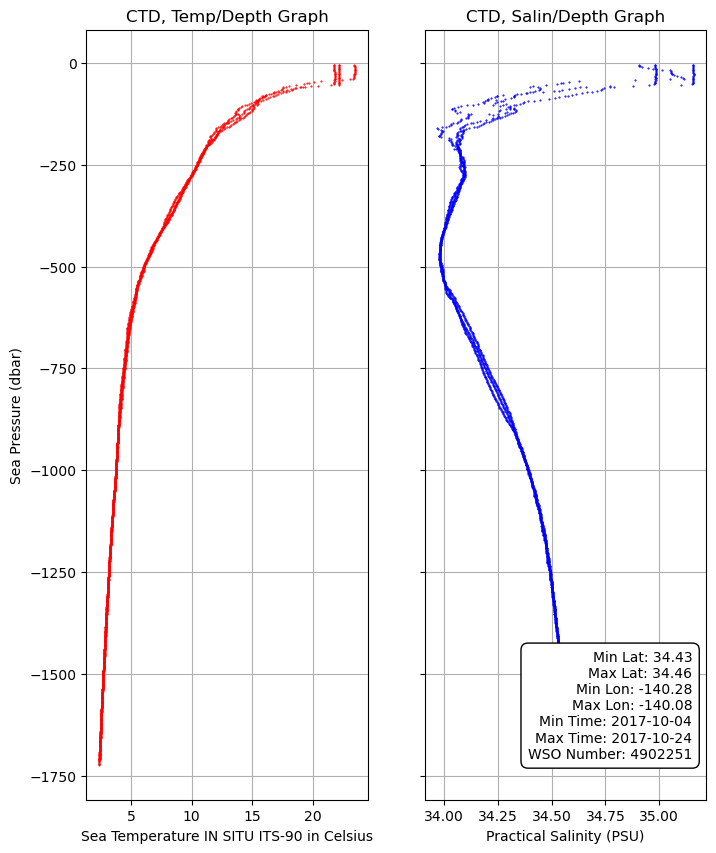

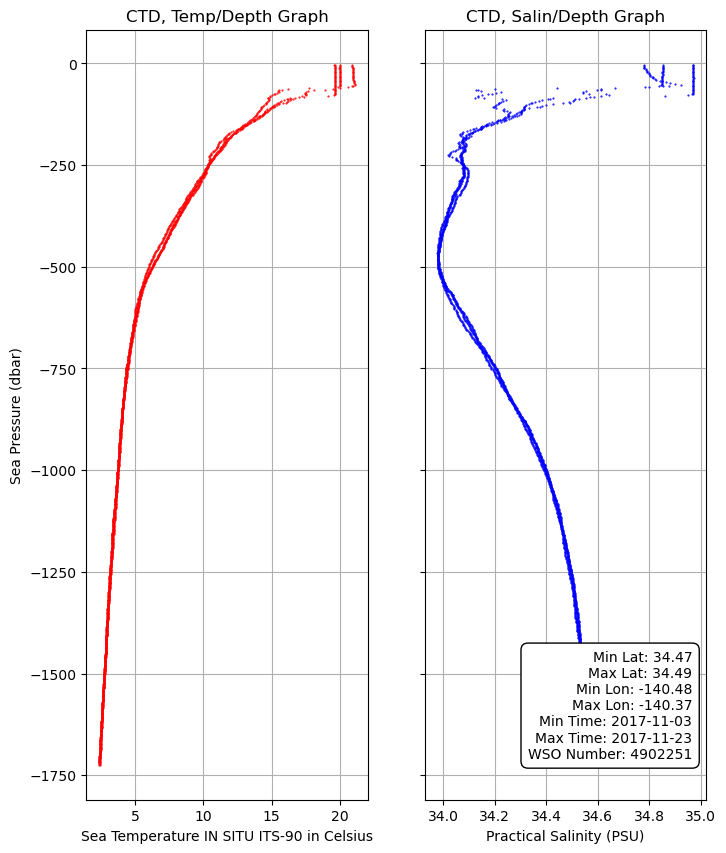

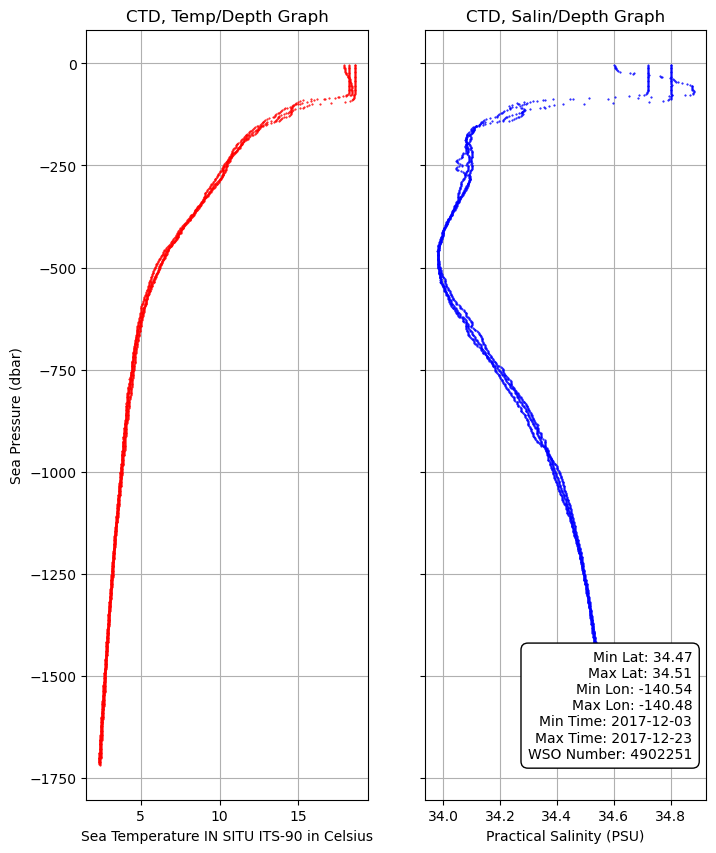

In [24]:
#The CTD graphs of each float chosen, month by month - But limited by lon, lat of Region #1, AND time!

sliced_data_list = []

a_values = [5903608, 5904128, 5904977, 4900816, 4902251]

for a in a_values:
    
    apDS = argo_loader.float(a).load().data
    data1 = apDS.argo.point2profile()
    data2 = data1.set_xindex("TIME")
    sliced_data = data2.sel(TIME=slice('2017-03-01','2017-12-31'))
    sliced_data_list.append(sliced_data)

import pandas as pd

def plot_graph_and_text(ax, sliced_data, a_values):
    # ... (rest of the function remains unchanged) ...
 # Calculate the max and min latitude and longitude values!
    max_lat = sliced_data.LATITUDE.max().values
    min_lat = sliced_data.LATITUDE.min().values
    max_lon = sliced_data.LONGITUDE.max().values
    min_lon = sliced_data.LONGITUDE.min().values
    min_time = pd.to_datetime(sliced_data.TIME.min().values).strftime('%Y-%m-%d')
    max_time = pd.to_datetime(sliced_data.TIME.max().values).strftime('%Y-%m-%d')
    wso_identifier = sliced_data.PLATFORM_NUMBER.min().values

    # Calculate the number of profiles DIMENSION!
    n_prof_value = sliced_data.N_PROF.values[0]

    # Temperature
    ax[0].plot(sliced_data.TEMP, -sliced_data.PRES, 'ro', markersize= .5)
    ax[0].set_xlabel('Sea Temperature IN SITU ITS-90 in Celsius')
    ax[0].set_ylabel('Sea Pressure (dbar)')
    ax[0].set_title('CTD, Temp/Depth Graph')
    ax[0].grid()

    # Salinity
    ax[1].plot(sliced_data.PSAL, -sliced_data.PRES, 'bo', markersize= .5)
    ax[1].set_title('CTD, Salin/Depth Graph')
    ax[1].set_xlabel('Practical Salinity (PSU)')
    ax[1].grid()

    # Provide a text box with important information like lat, lon, and the number of profiles!
    text_plot = f"Min Lat: {min_lat:.2f}\nMax Lat: {max_lat:.2f}\nMin Lon: {min_lon:.2f}\nMax Lon: {max_lon:.2f}\nMin Time: {min_time}\nMax Time: {max_time}\nWSO Number: {wso_identifier}"
    ax[1].text(0.95, 0.05, text_plot, transform=ax[1].transAxes, ha='right', va='bottom', fontsize=10,
               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
sliced_data_list = []
date_ranges = {
    5903608: [('2017-02-01', '2017-03-01'), ('2017-03-01', '2017-04-01'), ('2017-04-01', '2017-05-01'),
             ('2017-05-01', '2017-06-01'), ('2017-10-01', '2017-11-01'),
             ('2017-11-01', '2017-12-01'), ('2017-12-01', '2017-12-31')], 
    5904128: [('2017-07-01', '2017-08-01')],
    5904977: [('2017-11-01', '2017-12-01'), ('2017-12-01', '2017-12-31')],
    4900816: [('2017-06-01', '2017-07-01'), ('2017-07-01', '2017-08-01')],
    4902251: [('2017-07-01', '2017-08-01'), ('2017-08-01', '2017-09-01'), ('2017-09-01', '2017-10-01'), ('2017-10-01', '2017-11-01'),
             ('2017-11-01', '2017-12-01'), ('2017-12-01', '2017-12-31')],
    #Excluded because not in either of my hand-chosen regions = 4902149: [('2017-01-01', '2017-02-01'), ('2017-02-01', '2017-03-01'), ('2017-03-01', '2017-04-01'), ('2017-04-01', '2017-05-01'),
             #('2017-05-01', '2017-06-01'), ('2017-06-01', '2017-07-01'), ('2017-07-01', '2017-08-01'), ('2017-08-01', '2017-09-01'), ('2017-09-01', '2017-10-01'), ('2017-10-01', '2017-11-01'),
             #('2017-11-01', '2017-12-01'), ('2017-12-01', '2017-12-31')]
}

        
for a in a_values:
    apDS = argo_loader.float(a).load().data
    data1 = apDS.argo.point2profile()
    data2 = data1.set_xindex("TIME")

    for date_range in date_ranges[a]:
        sliced_data = data2.sel(TIME=slice(date_range[0], date_range[1]))
        sliced_data_list.append(sliced_data)

for i, sliced_data in enumerate(sliced_data_list):
    fig, ax = plt.subplots(1, 2, figsize=(8, 10), sharey=True)
    plot_graph_and_text(ax, sliced_data, a_values)

plt.show()  # Add this to display all the plots together